# TODO Titleb


Recommendation: Use Jupyter Lab -> View -> Render Side by Side, and Right Click on Cell -> Enable Scrolling for Outputs
Recommendation: Use Jupyter Lab's left side bar to navigate between sections

## TODO Introduction
- brief description of what the data is
- brief description of how I got the data
- link to blogposts

In [15]:
# Import, settings, and constants
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random
from time import perf_counter
from IPython.display import display
from importlib import reload
from core import analysis_utils as au
from core.analysis_utils import print_titled_text as titled, print_spacer as spacer

reload(au);

sns.set_theme(style='dark')
%matplotlib inline

CURRENT_YEAR = 2022
PATH_GENERAL_DATA = "./data/parquet/2022-09-19_general_data.parquet"
PATH_LINK_DATA = "./data/parquet/2022-09-19_link_data.parquet"
PATH_POLL_DATA = "./data/parquet/2022-09-19_poll_data.parquet"
#ASPECT_WIDE = 16/9
#ASPECT_NARROW = 4/3
#ASPECT_SQUARE = 1
#HEIGHT_STANDARD = 5
H_STD = 5
AS_W = 16/9
AS_N = 4/3
AS_SQ = 1

In [3]:
# Load the data
t1 = perf_counter()
gen = pd.read_parquet(PATH_GENERAL_DATA)
link = pd.read_parquet(PATH_LINK_DATA)
poll = pd.read_parquet(PATH_POLL_DATA)
t2 = perf_counter()
print(f"Loading took {t2 - t1:.2f} seconds.")

Loading took 5.23 seconds.


## General properties of the imported dataframes

## General Data


### Rated vs Unrated games
- all games may have have ratings
- BGG distinguishes that games over 30 ratings receive a "geek rating" [link], described here as `ratings_bayes_average`
- In this data set, unrated games receive a `ratings_bayes_average` of zero

In [6]:
rated = gen.query('ratings_bayes_average > 0')
unrated = gen.query('ratings_bayes_average == 0')

In [8]:
print(f"Number of games without/with geek rating: \n    "
      f"w/o - {unrated.shape[0]}, "
      f"w/ - {rated.shape[0]}."
     )

print(f"Without geek number of ratings min, max: "
      f"{unrated['ratings_n'].min()}, "
      f"{unrated['ratings_n'].max()}."
     )

print(f"With geek number of ratings min, max: "
      f"{rated['ratings_n'].min()}, "
      f"{rated['ratings_n'].max()}."
     )

Number of games without/with geek rating: 
    w/o - 84697, w/ - 23318.
Without geek number of ratings min, max: 0, 29.
With geek number of ratings min, max: 30, 113935.


- for games with more than thirty ratings, BGG obscures the actual ratings. This is because they have to rank the games. Games with a low number of ratings may have a high average rating because a very small number of highly-rated games.
- therefore bgg obscures these game ratings with dummy ratings
- here's a visualization of what that looks like

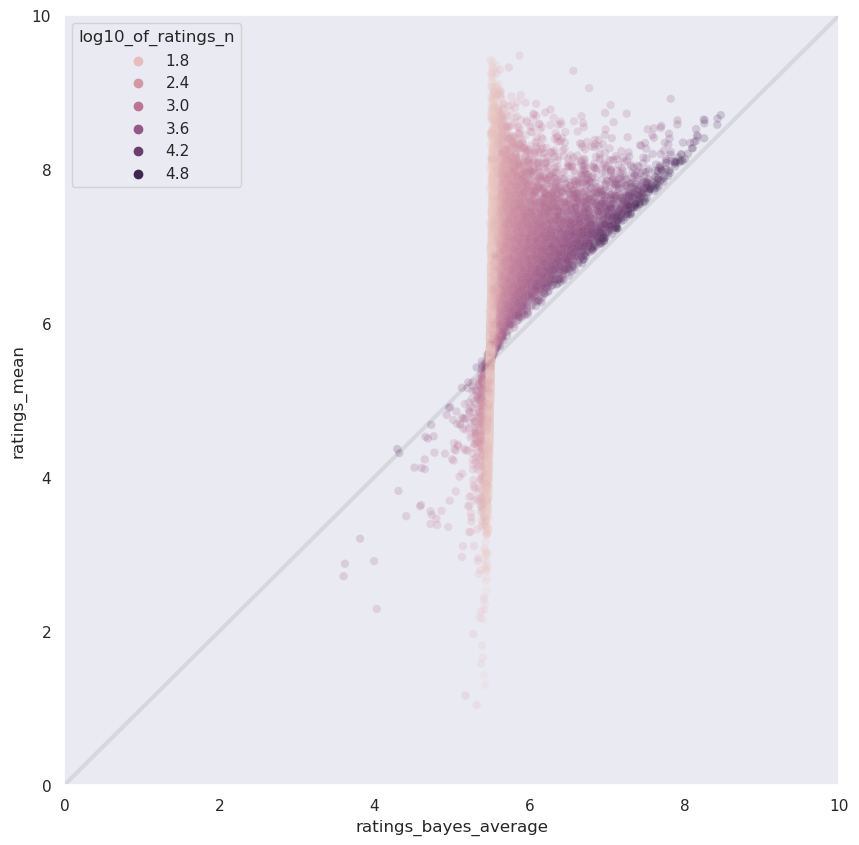

In [20]:
_data = rated.assign(log10_of_ratings_n = np.log10(rated['ratings_n']))
f, ax = plt.subplots(1, 1, figsize=(H_STD*2, )*2)
sns.scatterplot(ax=ax, data=_data, x='ratings_bayes_average', y='ratings_mean',
    hue='log10_of_ratings_n',
    linewidth=0.1, alpha=0.2
)

ax.set_xlim((0,10))
ax.set_ylim((0,10))

ax.plot([0,10],[0,10],
        alpha=0.08,
        linewidth=3,
        color='black');

- we know from previously that 
- [bayesian average](https://en.wikipedia.org/wiki/Bayesian_average)
- [could be 100 votes at 5.5](https://boardgamegeek.com/wiki/page/BoardGameGeek_FAQ)
- [previous estimate of 1500-1600 ratings of 5.5](https://boardgamegeek.com/blogpost/109537/reverse-engineering-boardgamegeek-ranking)



In [89]:
def compute_bayesian_average(rating_mean, rating_n, dummy_rating, num_dummies):
    return (
        ((rating_mean * rating_n) + (dummy_rating * num_dummies))
        /(rating_n + num_dummies)
        )

def vec_compute_bayesian_average(df, dummy_rating, num_dummies):
    return (
        ((df.ratings_mean * df.ratings_n) + (dummy_rating * num_dummies))
        /(df.ratings_n + num_dummies)
        )

def rmsd(y_trues, y_preds):
    """Compute RMSD.
    
    Args:
        y_ratings (np.ndarray or pd.Series): A 1D vector.
        y_preds (np.ndarray or pd.Series): A 1D vector.
    Returns:
        float: the root mean squared deviation.
    """
    assert len(y_trues.shape) == 1
    assert y_trues.shape == y_preds.shape
    return np.sqrt(((y_trues - y_preds)**2).sum() / y_trues.shape[0])

# Tests
def test_compute_bayes_average():
    mean, rating_n, dummy, num_dummies = 2, 3, 4, 5
    correct = 3.25
    result = compute_bayesian_average(mean, rating_n, dummy, num_dummies) 
    try: 
        assert result == correct 
    except AssertionError:
        print(f"FAIL: result was {result}, but should be {correct}.")
    else:
        print(f"PASS")

def test_vec_compute_bayesian_average():
    dummy, num_dummies = 5, 2
    df = pd.DataFrame({'ratings_mean':[1,1,2], 'ratings_n':[1,2,3]})
    correct = pd.Series([11/3, 12/4, 16/5])
    result = vec_compute_bayesian_average(df, dummy, num_dummies)
    try:
        assert np.equal(result.values, correct.values).all()
    except AssertionError:
        print(f"FAIL: result was \n{result}\n but should be \n{correct}.")
    else:
        print(f"PASS")

def test_rmsd():
    result = rmsd(np.array([1,2,3]), np.array([4,7,11]))
    correct = np.sqrt(98/3)
    try:
        assert result == correct
    except AssertionError:
        print(f"FAIL: result was {result}, but should be {correct}.")
    else:
        print(f"PASS")

test_compute_bayes_average()
test_vec_compute_bayesian_average()
test_rmsd()

PASS
PASS
PASS


In [92]:
bayes = (
    rated
    .assign(computed_bayes=vec_compute_bayesian_average(rated, 5.5, 1500))
)

print(f"RMSD computed Bayesian average: "
      f"{rmsd(bayes.computed_bayes, bayes.ratings_bayes_average):.6f}")

RMSD computed Bayesian average: 0.051999


In [104]:
from scipy.optimize import minimize

def error_wrapper(dummy_args):
    (dummy_rating, num_dummies) = dummy_args

    y_true = rated.ratings_bayes_average
    y_pred = vec_compute_bayesian_average(rated, dummy_rating, num_dummies) 
    error = rmsd(y_true, y_pred)
    return error 
    
print(error_wrapper((5.5, 1500)))

0.051999322298702674


In [105]:
op_res = minimize(error_wrapper, x0=(5.5, 1500), options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.019480
         Iterations: 34
         Function evaluations: 108
         Gradient evaluations: 36


In [106]:
print(op_res.x)

[   5.49561746 1972.46000073]


In [107]:
# TODO delete this
rmsd(rated.ratings_bayes_average, vec_compute_bayesian_average(rated, *op_res.x))



0.019480321333279833

In [ ]:
# TODO try chain ax methods


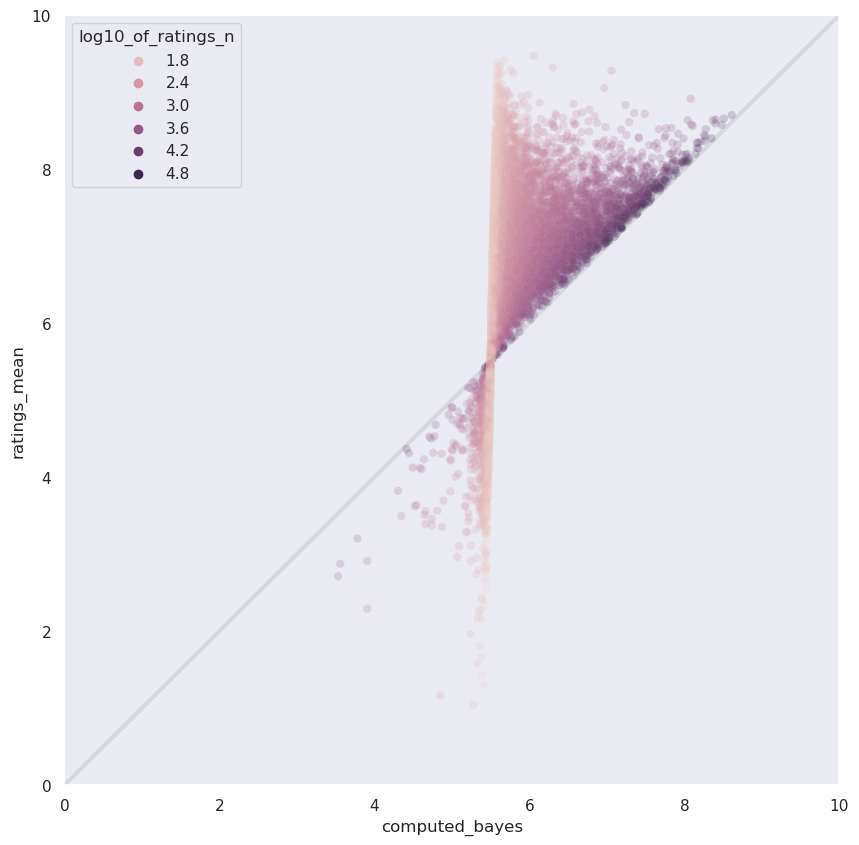

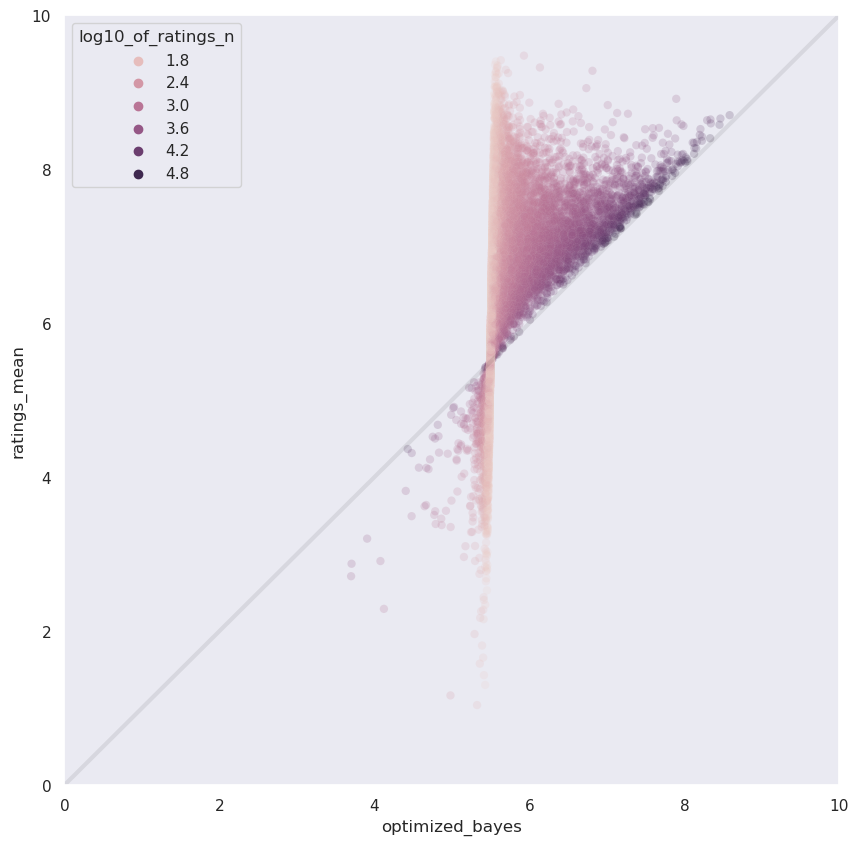

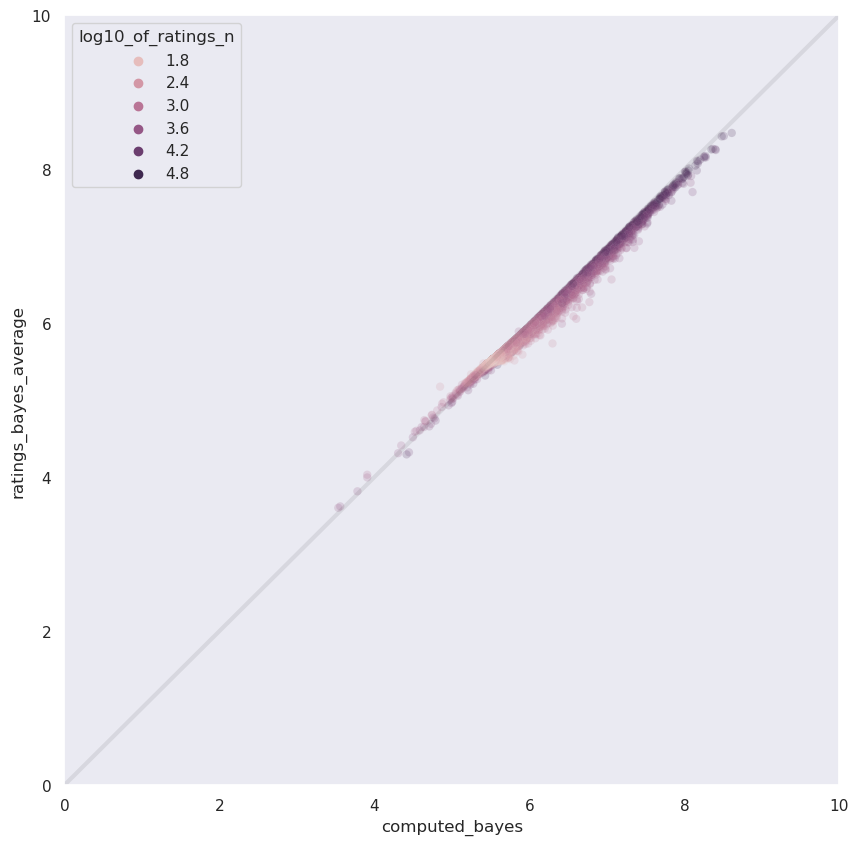

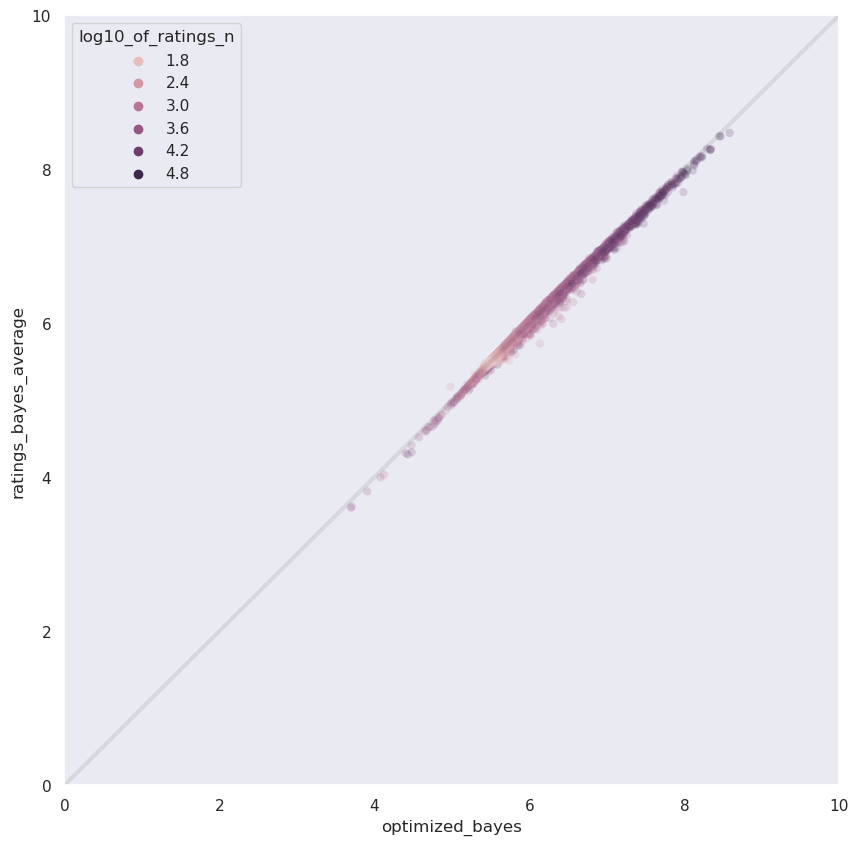

In [111]:
_data = (
    rated
    .assign(log10_of_ratings_n = np.log10(rated['ratings_n']))
    .assign(computed_bayes=vec_compute_bayesian_average(rated, 5.5, 1500))
    .assign(optimized_bayes=vec_compute_bayesian_average(rated, *op_res.x))
)

f, ax = plt.subplots(1, 1, figsize=(H_STD*2, )*2)

sns.scatterplot(ax=ax, data=_data, x='computed_bayes', y='ratings_mean',
    hue='log10_of_ratings_n',
    linewidth=0.1, alpha=0.2
)

ax.set_xlim((0,10))
ax.set_ylim((0,10))

ax.plot([0,10],[0,10],
        alpha=0.08,
        linewidth=3,
        color='black');

f, ax = plt.subplots(1, 1, figsize=(H_STD*2, )*2)

sns.scatterplot(ax=ax, data=_data, x='optimized_bayes', y='ratings_mean',
    hue='log10_of_ratings_n',
    linewidth=0.1, alpha=0.2
)

ax.set_xlim((0,10))
ax.set_ylim((0,10))

ax.plot([0,10],[0,10],
        alpha=0.08,
        linewidth=3,
        color='black');


f, ax = plt.subplots(1, 1, figsize=(H_STD*2, )*2)
sns.scatterplot(ax=ax, data=_data, x='computed_bayes', y='ratings_bayes_average',
    hue='log10_of_ratings_n',
    linewidth=0.1, alpha=0.2
)

ax.set_xlim((0,10))
ax.set_ylim((0,10))

ax.plot([0,10],[0,10],
        alpha=0.08,
        linewidth=3,
        color='black');

f, ax = plt.subplots(1, 1, figsize=(H_STD*2, )*2)
sns.scatterplot(ax=ax, data=_data, x='optimized_bayes', y='ratings_bayes_average',
    hue='log10_of_ratings_n',
    linewidth=0.1, alpha=0.2
)

ax.set_xlim((0,10))
ax.set_ylim((0,10))

ax.plot([0,10],[0,10],
        alpha=0.08,
        linewidth=3,
        color='black');

- split the data into rated and unrated parts for individual variable overview.

### Overview 

Most numbers are `int`, with `float` for statistical measures. Twenty-seven (27) games are missing descriptions.

In [5]:
au.print_titled_text("Nulls and Datatypes")
gen_df.info()
au.print_spacer()
au.print_null_count(gen_df)
au.print_spacer()
au.print_titled_text("Description")
display(gen_df.describe())

NULLS AND DATATYPES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108015 entries, 0 to 108014
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       108015 non-null  int64  
 1   type                     108015 non-null  object 
 2   name                     108015 non-null  object 
 3   description              107988 non-null  object 
 4   year_published           108015 non-null  int64  
 5   players_min              108015 non-null  int64  
 6   players_max              108015 non-null  int64  
 7   playtime                 108015 non-null  int64  
 8   playtime_min             108015 non-null  int64  
 9   playtime_max             108015 non-null  int64  
 10  age_min                  108015 non-null  int64  
 11  ratings_n                108015 non-null  int64  
 12  ratings_mean             108015 non-null  float64
 13  ratings_bayes_average    108015 non-nul

,id,year_published,players_min,players_max,playtime,playtime_min,playtime_max,age_min,ratings_n,ratings_mean,ratings_bayes_average,ratings_stddev,ratings_median,ratings_owned,ratings_trading,ratings_wanting,ratings_wishing,ratings_comments_n,ratings_weights_n,ratings_weights_average
count,108015.000000,108015.000000,108015.000000,108015.000000,1.080150e+05,108015.000000,1.080150e+05,108015.000000,108015.000000,108015.000000,108015.000000,108015.000000,108015.0,108015.000000,108015.000000,108015.000000,108015.000000,108015.000000,108015.000000,108015.000000
mean,144502.139046,1826.884525,1.992279,6.459381,1.095789e+03,41.055659,1.095789e+03,7.484081,194.979262,4.584989,1.226673,0.899536,0.0,340.307948,9.703402,9.470861,54.275573,47.778383,10.928158,0.846159
std,116161.241706,567.429968,0.846712,49.568074,2.179718e+05,556.653931,2.179718e+05,7.816799,1802.471195,2.984667,2.343914,0.882034,0.0,2675.559029,51.038205,55.819807,393.731692,327.203946,97.638728,1.101630
min,1.000000,-3500.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31041.500000,1988.000000,2.000000,2.000000,1.000000e+01,10.000000,1.000000e+01,4.000000,1.000000,1.000000,0.000000,0.000000,0.0,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,129564.000000,2008.000000,2.000000,4.000000,3.000000e+01,20.000000,3.000000e+01,8.000000,3.000000,5.583000,0.000000,1.000000,0.0,8.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
75%,247799.500000,2016.000000,2.000000,6.000000,6.000000e+01,45.000000,6.000000e+01,12.000000,21.000000,6.769000,0.000000,1.533850,0.0,57.000000,2.000000,2.000000,9.000000,10.000000,2.000000,1.667000
max,362381.000000,2026.000000,50.000000,11299.000000,6.307200e+07,157680.000000,6.307200e+07,2017.000000,113935.000000,10.000000,8.469000,4.500000,0.0,178195.000000,2741.000000,1960.000000,20430.000000,20125.000000,7854.000000,5.000000


In [6]:
null_desc = gen_df[gen_df['description'].isnull()]
display(null_desc)
au.print_spacer()
au.print_titled_text('links')
au.display_id_link(null_desc['id'].iloc[0])

,id,type,name,description,year_published,players_min,players_max,playtime,playtime_min,playtime_max,...,ratings_bayes_average,ratings_stddev,ratings_median,ratings_owned,ratings_trading,ratings_wanting,ratings_wishing,ratings_comments_n,ratings_weights_n,ratings_weights_average
385,224083,boardgame,Trono Oscuro,None,2017,2,5,120,60,120,...,0.000,0.0000,0.0,3,0,0,1,1,0,0.0
7724,243593,boardgame,Bastille: Fallen Kingdoms,None,2017,3,6,1400,60,1400,...,0.000,0.0000,0.0,0,0,0,0,0,0,0.0
13398,146535,boardgame,Math Battleship Game,None,2013,1,0,30,30,30,...,0.000,0.0000,0.0,0,0,0,1,0,0,0.0
14112,320241,boardgame,Electric Orchard,None,2021,2,4,60,30,60,...,0.000,0.0000,0.0,0,0,1,2,0,0,0.0
19282,174579,boardgame,Ex-Machina,None,2015,2,4,10,6,10,...,0.000,0.0000,0.0,3,0,0,1,0,0,0.0
23952,261574,boardgame,Black Hole,None,2018,1,4,40,20,40,...,0.000,0.0000,0.0,2,0,1,0,1,0,0.0
24162,180869,boardgame,Off with His Straw Head,None,2015,3,5,10,10,10,...,0.000,0.0000,0.0,4,0,0,0,0,0,0.0
27085,112878,boardgame,Ammo Domini: Fight for Europe to the Last Bullet,None,2012,2,5,0,0,0,...,0.000,0.0000,0.0,0,0,1,12,0,0,0.0
28344,174577,boardgame,Into the Rabbit Hole,None,2015,2,5,15,10,15,...,0.000,0.0000,0.0,5,0,0,0,0,0,0.0
28357,170984,boardgame,Timeline: Sports et Loisirs,None,2014,2,8,15,15,15,...,5.533,1.6166,0.0,178,2,7,32,10,2,1.0





LINKS
=====


#### Duplication check

In [7]:
au.print_titled_text('Duplicated rows')
gen_df.duplicated().sum()

DUPLICATED ROWS


0

### Missing Data
TODO missing data hiding as zeros

In [8]:
# pair plot of name to age min
gen_df_subset = gen_df.loc[:,'name':'age_min']

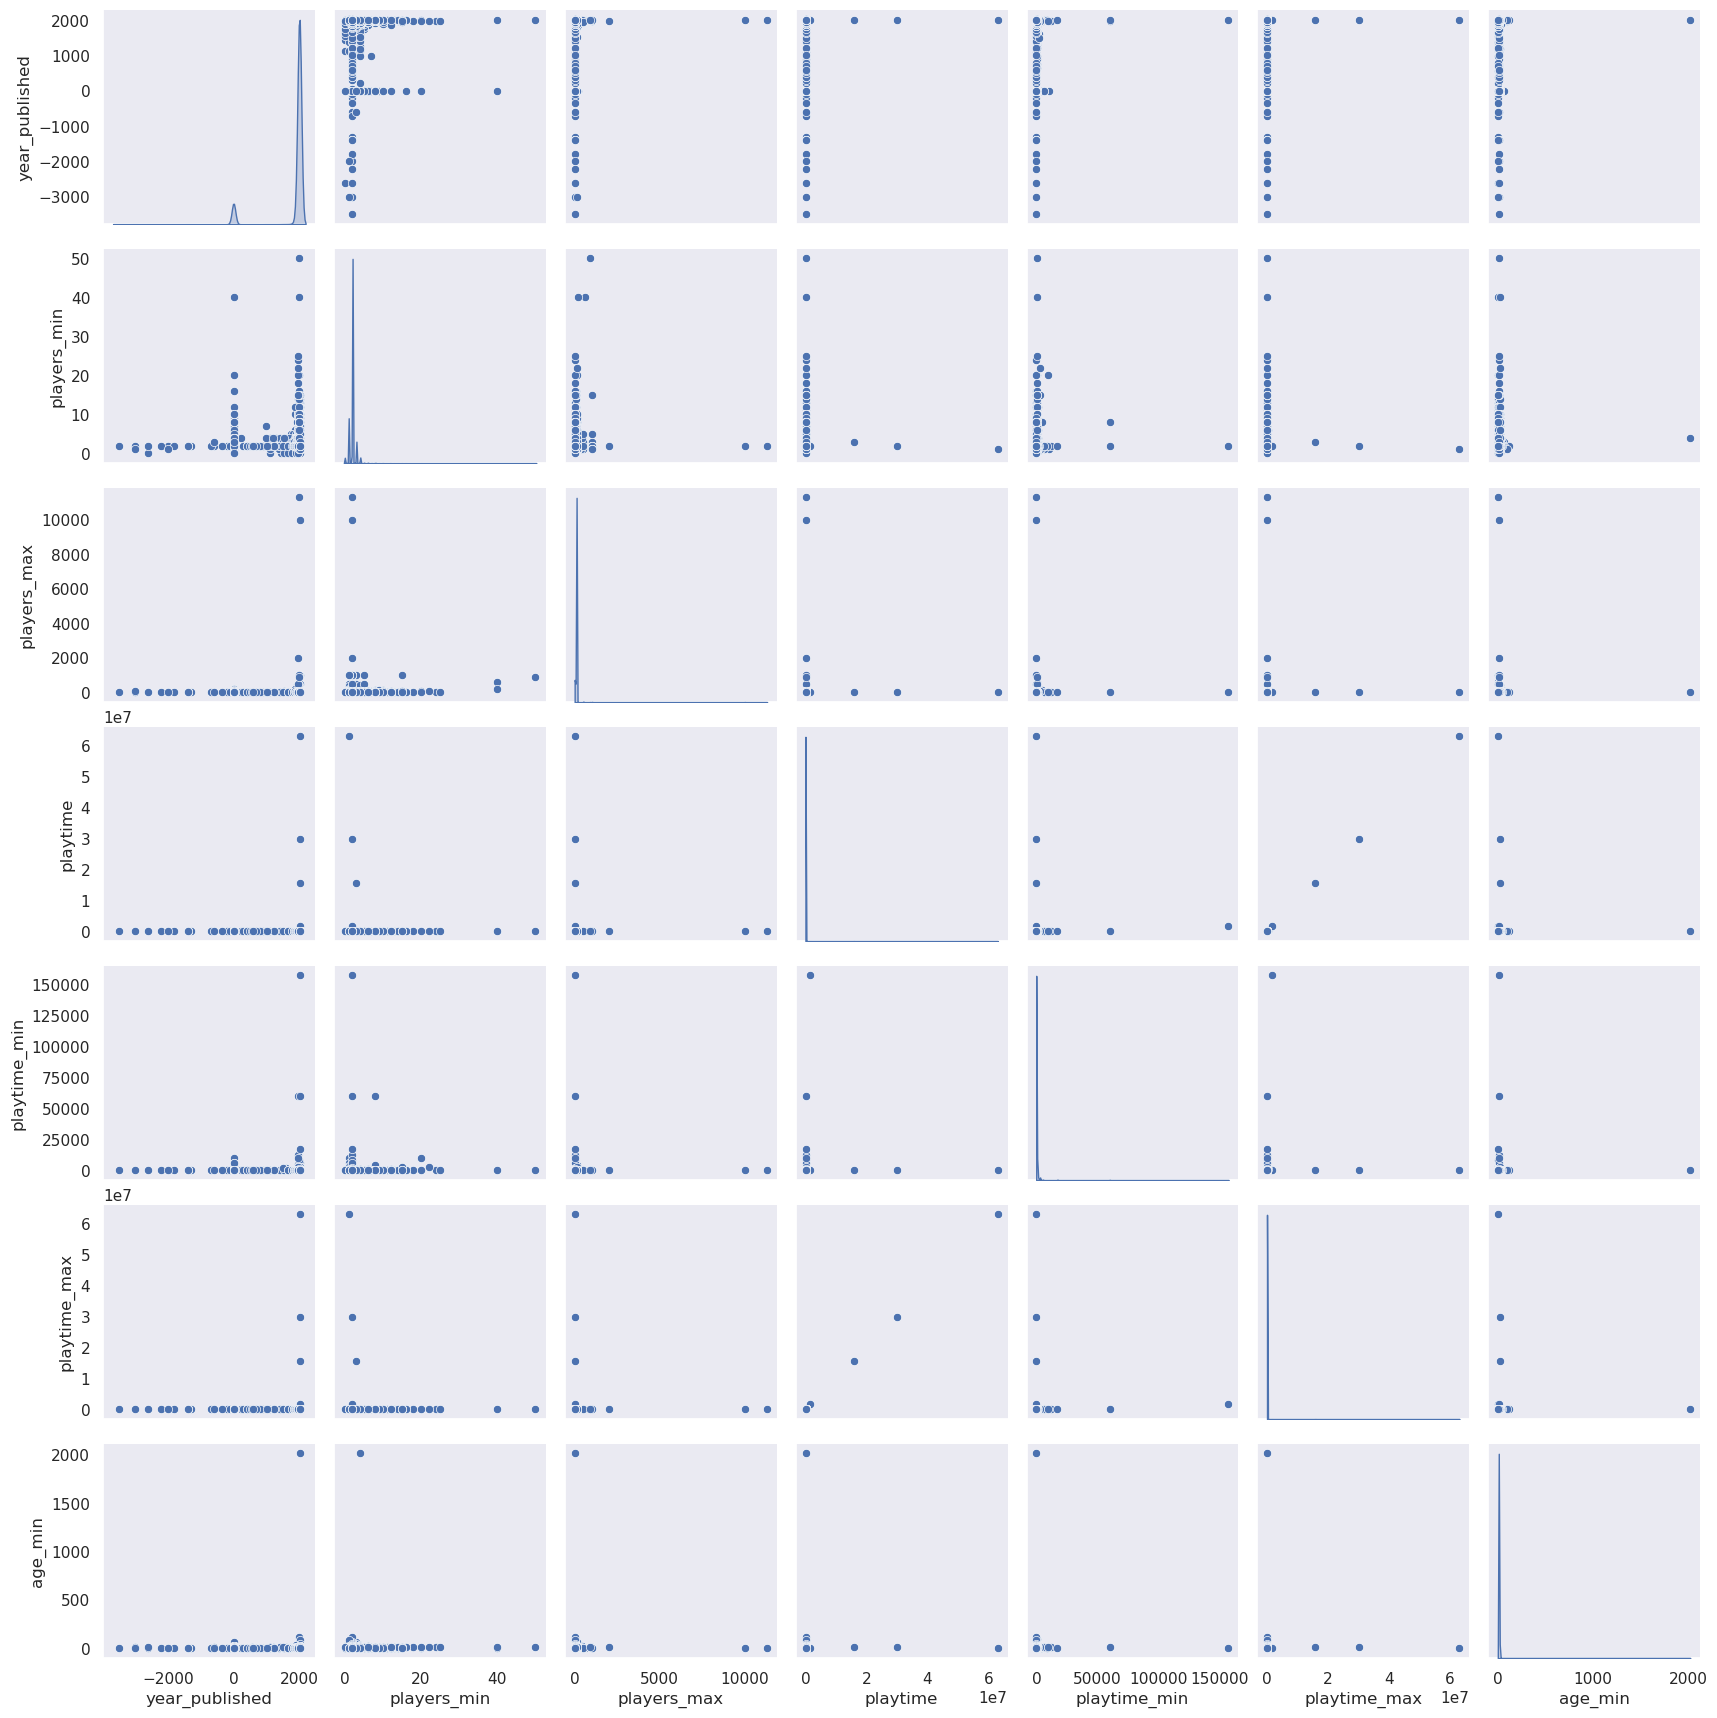

In [9]:
g = sns.pairplot(data=gen_df_subset, diag_kind='kde')

In [10]:
(gen_df['name'] == "").mean()

0.0

In [11]:
gen_df.iloc[gen_df['name'].str.len().idxmin(), 0:4]

id                                                           872
type                                                   boardgame
name                                                           M
description    An abstract strategy game where players attemp...
Name: 9155, dtype: object

In [12]:
gen_df.iloc[gen_df['description'].str.len().idxmin(),:]

id                            109575
type                       boardgame
name                       Val-Terra
description                    .\n\n
year_published                     0
players_min                        2
players_max                        4
playtime                          45
playtime_min                      30
playtime_max                      45
age_min                           10
ratings_n                          0
ratings_mean                     0.0
ratings_bayes_average            0.0
ratings_stddev                   0.0
ratings_median                   0.0
ratings_owned                      1
ratings_trading                    0
ratings_wanting                    0
ratings_wishing                    1
ratings_comments_n                 0
ratings_weights_n                  0
ratings_weights_average          0.0
Name: 8133, dtype: object

In [13]:
(gen_df['year_published'] != 0).astype(int).mean()

0.9131324353099106

In [14]:
def display_missing_probs(df: pd.DataFrame) -> pd.DataFrame:
    """
    
    Args:
        df: DataFrame containing general BGG data.
        
    Returns:
         pd.DataFrame:
    """
    NUMERICAL_COLS = ['year_published', 'players_min', 'players_max', 'playtime', 'playtime_min', 'playtime_max', 'age_min']
    
    bool_df = []
    #
    for col in NUMERICAL_COLS:
        bool_df.append((df[col] != 0).astype(int))
        
    bool_df = pd.concat(bool_df, axis=1)
    display(bool_df.T.dot(bool_df))
#     for col in NUMERICAL_COLS:
#         display(bool_df.groupby(col).mean())

        
# TODO describe what im actually computing here
display_missing_probs(gen_df)

# Want some sort of table...
    

,year_published,players_min,players_max,playtime,playtime_min,playtime_max,age_min
year_published,98632,97169,94161,78970,80447,78970,79230
players_min,97169,106127,102504,84148,85748,84148,84785
players_max,94161,102504,102616,82838,84345,82838,83009
playtime,78970,84148,82838,84346,84198,84346,73327
playtime_min,80447,85748,84345,84198,85952,84198,74847
playtime_max,78970,84148,82838,84346,84198,84346,73327
age_min,79230,84785,83009,73327,74847,73327,85325


### Individual Variable Overview

In this section, we take a look at each variable outputting summary plots as needed.

#### `id`

Each boardgame has a unique id associated with it. Binning the ids shows that there are more "missing" ids not in the dataset (i.e. with bin widths of 10000, bin counts don't reach 10000). Since we only downloaded boardgames from the Board Game Geek server, the missing ids presumably do not belong to board game items. The rate of missing ids increases around `id` ~ 50000 when the ids are ordered sequentially.

In [15]:
# Descriptive stats
gen_df.id.describe()

count    108015.000000
mean     144502.139046
std      116161.241706
min           1.000000
25%       31041.500000
50%      129564.000000
75%      247799.500000
max      362381.000000
Name: id, dtype: float64

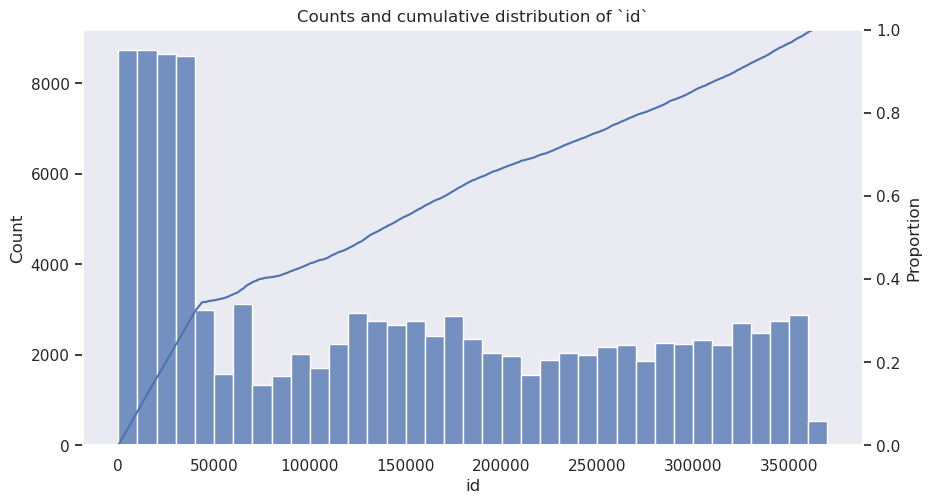

In [16]:
# Plot histogram counts and ecdf
g = sns.displot(data=gen_df,
            x='id',
            binwidth=10_000,
            height=HEIGHT_STANDARD,
            aspect=ASPECT_WIDE);

ax2 = g.ax.twinx()

sns.ecdfplot(ax=ax2,
             data=gen_df,
             x='id'
            );

g.set(title='Counts and cumulative distribution of `id`');




The plot shows how many missing ids are between each sequentially ordered id. An `id_diff` of `1` indicates no id is missing between a pair of ids. The maximium difference is 197.

count    108014.000000
mean          3.354935
std           5.792682
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max         197.000000
Name: id_diff, dtype: float64


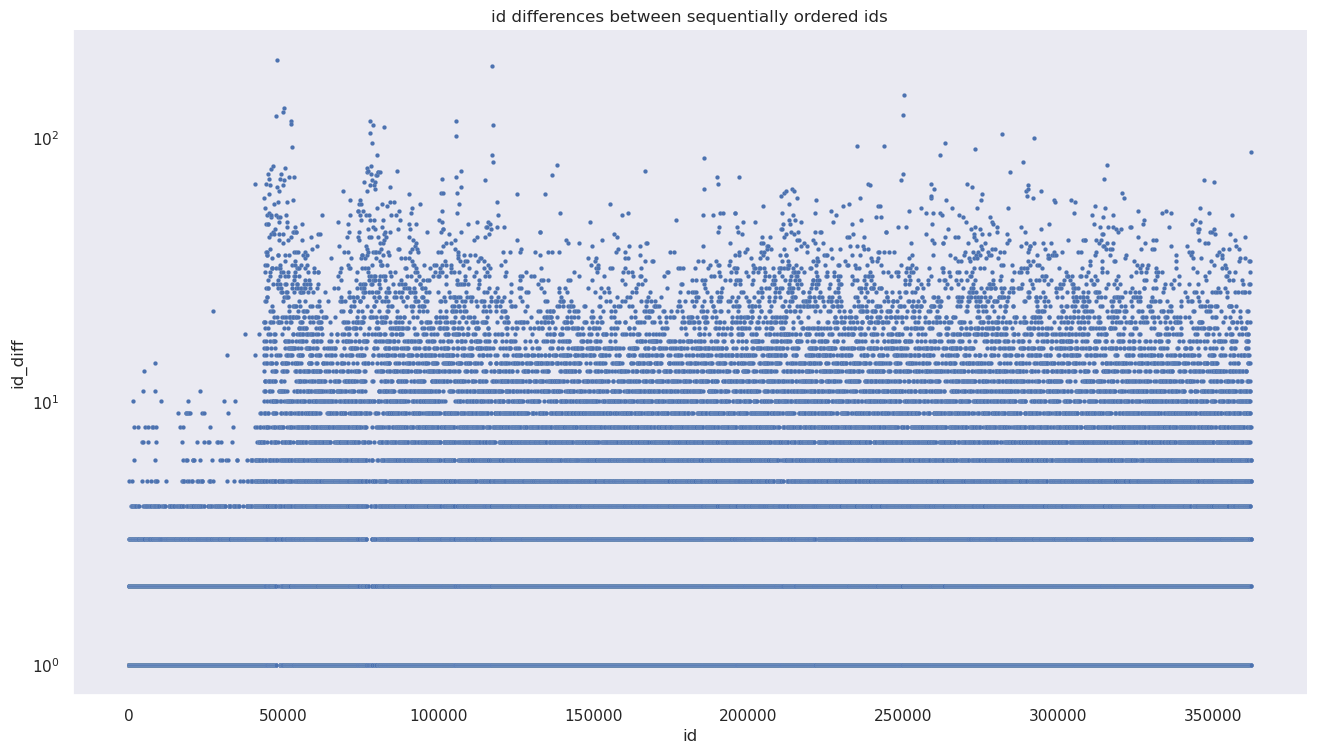

In [17]:
# Compute difference between an id and its preceding id.
# I.e., a diff > 1 indicates a missing id number
def make_id_diffs(df: pd.DataFrame,
                  id_key: str = 'id',
                  diffs_key: str = 'id_diff',
                  name_key: str = 'name') -> pd.DataFrame:
    ids_sorted = df[[id_key, name_key]].sort_values(by=id_key)
    ids_diff = ids_sorted[id_key].diff()
    out = pd.concat([ids_sorted, ids_diff],
                    axis=1,
                    ignore_index=True)
    out.columns = [id_key, name_key, diffs_key]
    return out


id_diffs = make_id_diffs(gen_df)
g = sns.relplot(data=id_diffs,
            x='id',
            y='id_diff',
            kind='scatter',
            height=HEIGHT_STANDARD*1.5,
            aspect=ASPECT_WIDE,
            linewidth=0.05,
            s=10,
            );
g.set(yscale='log');

g.set(title="id differences between sequentially ordered ids");

print(id_diffs['id_diff'].describe())



A cursory sampling of the missing ids suggests that missing ids < ~50000 are from board game expansions (e.g.24714), whereas those > ~ 50000 include various other objects including tabletop rpg ruleset books (e.g. 337080) and video games (e.g. 240813). Missings ids also include ids that are no longer assigned to any item (e.g. 20723), redirects (e.g. 9517 redirects to 2065).

This suggest that BGG changed policy about what items they would track around id ~ 50000.

In [18]:
# Display links for a sampling of missing ids before and after id == 50000
missing_ids = set([i for i in range(1, gen_df['id'].max())]) - set(gen_df['id'])
assert len(missing_ids) == (gen_df['id'].max() - gen_df.shape[0])

random.seed(7)
au.print_titled_text("Early ids")
for i in random.sample([e for e in missing_ids if e < 40000], 5):
    au.display_id_link(i)
au.print_titled_text("Later ids")
for i in random.sample([e for e in missing_ids if e > 60000], 5):
    au.display_id_link(i)

EARLY IDS


LATER IDS


#### `type`

Only items of type `boardgame` were downloaded from the server, (excluding boardgame expansions and accessories), so having only one type here is expected.

In [19]:
gen_df['type'].value_counts()

boardgame    108015
Name: type, dtype: int64

#### `year_published`


Publication years for board games extend from -3500 to 2026, with most games being published since the year 2000.

There is a large number of games annotated with the publication year as 0.


count    108015.000000
mean       1826.884525
std         567.429968
min       -3500.000000
25%        1988.000000
50%        2008.000000
75%        2016.000000
max        2026.000000
Name: year_published, dtype: float64


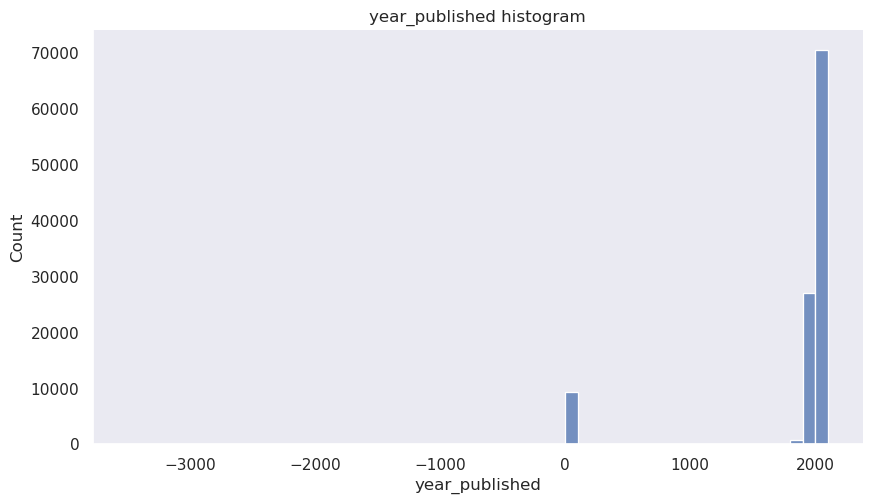

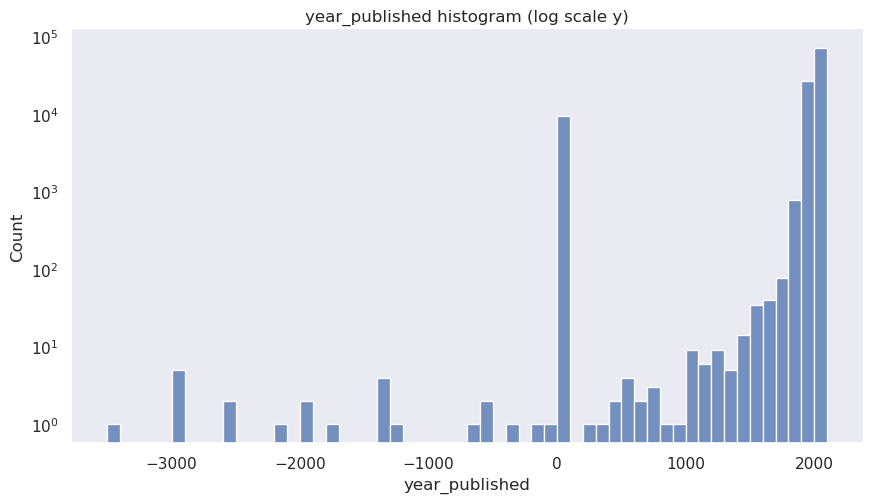

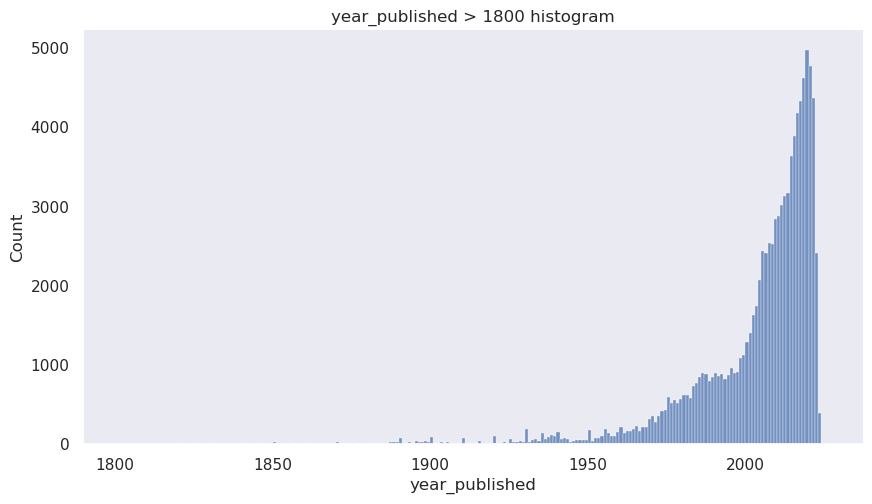

In [20]:
print(gen_df['year_published'].describe())

# Games by year published
g = sns.displot(data=gen_df,
                x='year_published',
                binwidth=100,
                height=HEIGHT_STANDARD,
                aspect=ASPECT_WIDE,);

g.set(title="year_published histogram");

# Games by year published, log scale
g = sns.displot(data=gen_df,
                x='year_published',
                binwidth=100,
                log_scale=(False, True),
                height=HEIGHT_STANDARD,
                aspect=ASPECT_WIDE,);

g.set(title="year_published histogram (log scale y)");

# Zoom in on games since 1800
gt_year = 1800
g = sns.displot(data=gen_df.query(f"year_published > {gt_year}"),
                x='year_published',
                binwidth=1,
                height=HEIGHT_STANDARD,
                aspect=ASPECT_WIDE,);

g.set(title=f"year_published > {gt_year} histogram");

Games annotated with a publication year of zero comprise ~9% of the dataset.

These games appear to actually be modern games using `0` as missing value placeholder.

In [21]:
year_published_zero = (gen_df.query("year_published == 0"))

# Proportion of games at year_published == 0
au.print_titled_text("Percentage year_published == 0")
print(f"{(gen_df.year_published == 0).mean():.1%}")

# Head of these games
au.print_spacer()
au.print_titled_text("year_published == 0 head")
display(year_published_zero.head())

# Sampling these games
au.print_spacer()
au.print_titled_text("Sample year_published == 0")
au.display_id_links_from_df(year_published_zero.sample(5, random_state=7))


PERCENTAGE YEAR_PUBLISHED == 0
8.7%



YEAR_PUBLISHED == 0 HEAD


,id,type,name,description,year_published,players_min,players_max,playtime,playtime_min,playtime_max,...,ratings_bayes_average,ratings_stddev,ratings_median,ratings_owned,ratings_trading,ratings_wanting,ratings_wishing,ratings_comments_n,ratings_weights_n,ratings_weights_average
7,304743,boardgame,Absolute Dice: Word,Fun Word version of the original Absolute Dice...,0,0,0,0,0,0,...,0.000,0.0000,0.0,3,0,0,0,1,0,0.000
12,10502,boardgame,Poker Dice,Poker Dice is a dice game using five (5) speci...,0,2,12,10,10,10,...,5.394,1.7863,0.0,1040,13,7,20,177,54,1.259
16,316761,boardgame,Skull Lantern,Skull Lantern is based on the fairy tale of Ba...,0,1,4,30,30,30,...,0.000,0.0000,0.0,0,0,0,0,0,0,0.000
37,20333,boardgame,LSUopoly,"The Game Includes:\n\nTokens:\nAlarm Clock, Pe...",0,2,5,120,120,120,...,0.000,0.4714,0.0,12,0,0,0,1,0,0.000
38,72761,boardgame,Fragments,A 1920s party game in which participants hunt ...,0,0,0,0,0,0,...,0.000,0.0000,0.0,0,0,0,1,0,0,0.000





SAMPLE YEAR_PUBLISHED == 0


Removing these games, we confirm that the overwhelming majority of games are published in the 20th century, with over half since 2010.

In [22]:
year_published_no_zeros = gen_df.query('year_published != 0')['year_published']

au.print_titled_text("year_published percentiles")
for q in np.array([1, 5, 6, 7, 8, 9, 10, 15, 20, 25, 50, 75])/100:
    print(
        f"{q:.0%} percentile: "
        f"{year_published_no_zeros.quantile(q):.0f}"
    )


YEAR_PUBLISHED PERCENTILES
1% percentile: 1899
5% percentile: 1962
6% percentile: 1967
7% percentile: 1971
8% percentile: 1973
9% percentile: 1975
10% percentile: 1977
15% percentile: 1985
20% percentile: 1991
25% percentile: 1996
50% percentile: 2010
75% percentile: 2017


For games published in the 21st century, there is a dropoff after 2020. I suspect this is probably because it takes time for games to get added, especially they are lesser known.

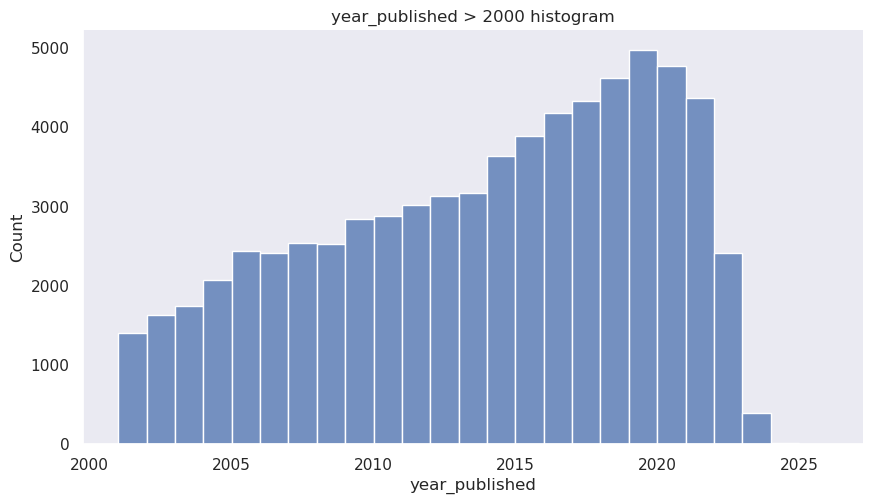

In [23]:
gt_year = 2000
g = sns.displot(data=gen_df.query(f"year_published > {gt_year}"),
                x='year_published',
                binwidth=1,
                height=HEIGHT_STANDARD,
                aspect=ASPECT_WIDE,);

g.set(title=f"year_published > {gt_year} histogram");

This is a sampling of games from different time periods. Some additional observations:
- Games published before the year 0 do in fact appear to be genuine ancient games (although assigning them to a specific year is arbitrarily precise)
- Some games are set to be published with the future (i.e. year > 2022). For example [Pharmageddon](https://www.kickstarter.com/projects/pharmageddon/pharmageddon-bugs-vs-drugs) has a finished kickstarter, but is not released yet.

Historical games (year < 2000) are kind of interesting to take a look through. 


In [24]:
year_bounds = [gen_df['year_published'].min(), 0, 1, 1800, 1900, 1950, 1980, 2000, 2022,
               gen_df['year_published'].max() + 1]

for start, end in zip(year_bounds[:-1], year_bounds[1:]):
    au.print_spacer()
    au.print_titled_text(
        f"Example games with published year"
        f" >= {start} and < {end}"
    )
    au.display_id_links_from_df(
        gen_df.query(f"(year_published >= {start}) and (year_published < {end})")\
        .sample(5, random_state=7)
    )




EXAMPLE GAMES WITH PUBLISHED YEAR >= -3500 AND < 0





EXAMPLE GAMES WITH PUBLISHED YEAR >= 0 AND < 1





EXAMPLE GAMES WITH PUBLISHED YEAR >= 1 AND < 1800





EXAMPLE GAMES WITH PUBLISHED YEAR >= 1800 AND < 1900





EXAMPLE GAMES WITH PUBLISHED YEAR >= 1900 AND < 1950





EXAMPLE GAMES WITH PUBLISHED YEAR >= 1950 AND < 1980





EXAMPLE GAMES WITH PUBLISHED YEAR >= 1980 AND < 2000





EXAMPLE GAMES WITH PUBLISHED YEAR >= 2000 AND < 2022





EXAMPLE GAMES WITH PUBLISHED YEAR >= 2022 AND < 2027


Note: there are 401 games with year > 2022 in this dataset.

In [25]:
au.print_spacer()
au.print_titled_text("games w/ year_published > 2022")
print(gen_df.query("year_published > 2022").shape[0])




GAMES W/ YEAR_PUBLISHED > 2022
401


#### `players_min` and `players_max`


TODO, two variable plot, and single plots

In [26]:
au.print_titled_text("players min")
print(gen_df.players_min.describe())
au.print_spacer()
au.print_titled_text("players max")
print(gen_df.players_max.describe())

PLAYERS MIN
count    108015.000000
mean          1.992279
std           0.846712
min           0.000000
25%           2.000000
50%           2.000000
75%           2.000000
max          50.000000
Name: players_min, dtype: float64



PLAYERS MAX
count    108015.000000
mean          6.459381
std          49.568074
min           0.000000
25%           2.000000
50%           4.000000
75%           6.000000
max       11299.000000
Name: players_max, dtype: float64


In [27]:
gen_df.query('players_min==0').head()

,id,type,name,description,year_published,players_min,players_max,playtime,playtime_min,playtime_max,...,ratings_bayes_average,ratings_stddev,ratings_median,ratings_owned,ratings_trading,ratings_wanting,ratings_wishing,ratings_comments_n,ratings_weights_n,ratings_weights_average
7,304743,boardgame,Absolute Dice: Word,Fun Word version of the original Absolute Dice...,0,0,0,0,0,0,...,0.0,0.0000,0.0,3,0,0,0,1,0,0.0
28,47019,boardgame,Fantastico 4,Board game of the year 1983 taken from a very ...,1983,0,0,0,0,0,...,0.0,0.0000,0.0,8,1,0,0,0,1,2.0
38,72761,boardgame,Fragments,A 1920s party game in which participants hunt ...,0,0,0,0,0,0,...,0.0,0.0000,0.0,0,0,0,1,0,0,0.0
82,71542,boardgame,Iropoly,The Iranian edition of the classic Monopoly ga...,0,0,0,0,0,0,...,0.0,3.3921,0.0,6,0,0,3,2,1,2.0
109,4065,boardgame,Crime Busters,"Players are shown a picture of a ""crime scene""...",1986,0,0,30,30,30,...,0.0,1.7555,0.0,93,5,0,1,17,1,1.0


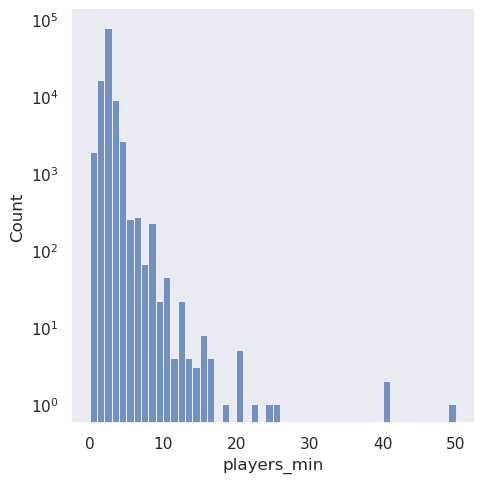

In [28]:
g = sns.displot(data=gen_df,
                x='players_min',
                binwidth=1,
                log_scale=(False, True))

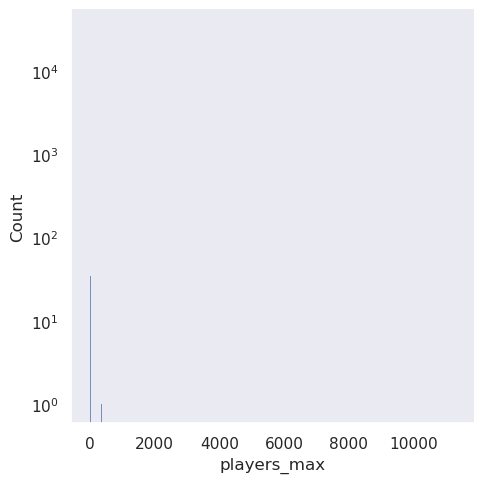

In [29]:
g = sns.displot(data=gen_df,
                x='players_max',
                binwidth=1,
                log_scale=(False,True)
            )

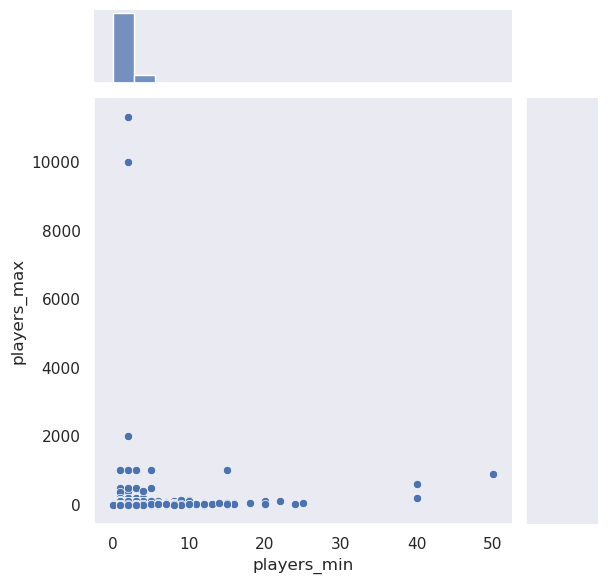

In [30]:
g = sns.jointplot(data=gen_df,
                  x='players_min',
                  y='players_max',
                  )

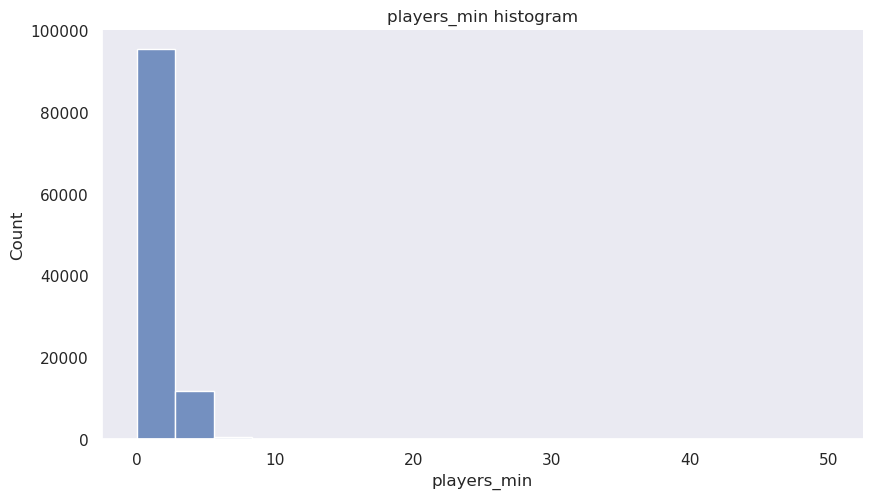

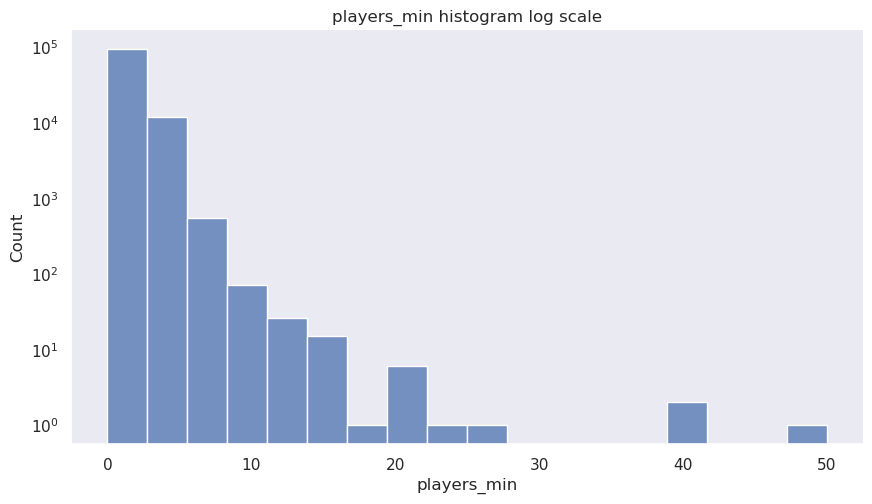

In [31]:
g = sns.displot(
        data=gen_df,
        x='players_min',
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE,
);

g.set(title="players_min histogram");

g = sns.displot(
        data=gen_df,
        x='players_min',
        log_scale=(False, True),
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE,
);

g.set(title="players_min histogram log scale");

#### `playtime`, `playtime_min`, and `playtime_max`

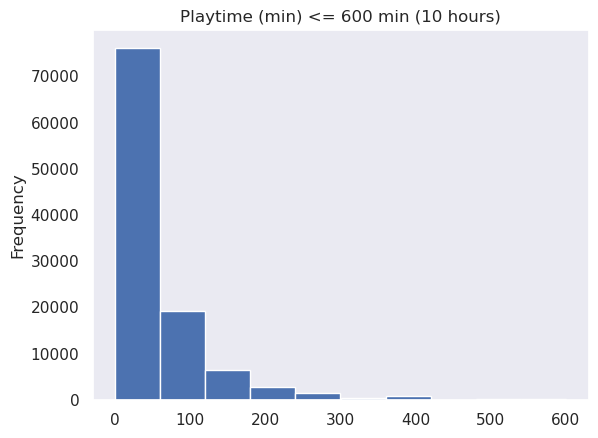

In [61]:
pt_s = gen_df['playtime']
pt_s[pt_s <= 600].plot.hist(title='Playtime (min) <= 600 min (10 hours)');

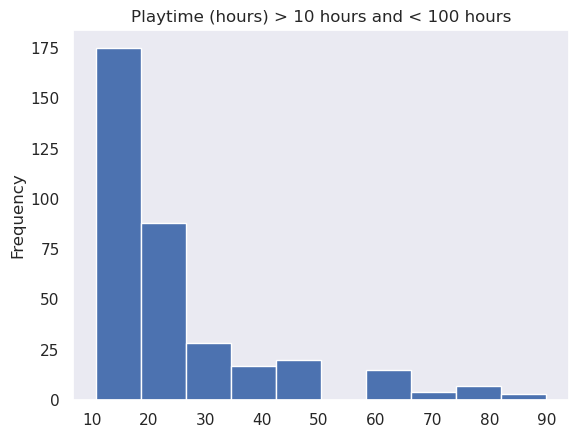

In [60]:
(pt_s
     .divide(60) # convert to hours
     [lambda s: (s > 10) & (s < 100)]
     .plot.hist(title='Playtime (hours) > 10 hours and < 100 hours')
);

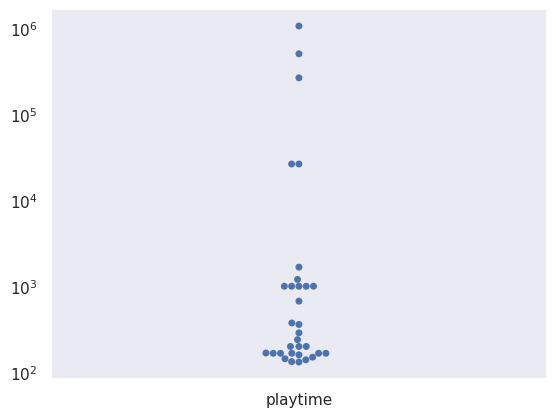

In [75]:
ax = sns.swarmplot(
    data=(pt_s
            .divide(60)
            [lambda s: s > 100]).to_frame()
)

ax.set_yscale('log')

In [ ]:
g = sns.displot(
        data=gen_df,
        x='playtime_min',
        binwidth=1_000_000,
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE,
)

g.set(title="playtime_min histogram");

In [ ]:
g = sns.displot(
            data=gen_df,
            x='playtime_max',
            binwidth=1_000_000,
            height=HEIGHT_STANDARD,
            aspect=ASPECT_WIDE,
)

g.set(title="playtime_max histogram");

In [ ]:
gen_df[(gen_df['playtime']> 1200)].describe()

In [ ]:
au.display_id_link(317582)

In [ ]:
display(gen_df[gen_df['playtime'] == gen_df['playtime'].max()])
au.display_id_link(351507)


In [ ]:
def plot_playtimes(df: pd.DataFrame) -> None:
    f, ax = plt.subplots(figsize=(5,5))
    # should be... x is time, y is count, based on sort of playtime
    playtimes = df[['playtime',
                    'playtime_min',
                    'playtime_max']].reset_index()
    ax.plot(df['playtime'], df.index)
    
plot_playtimes(gen_df)
    
    

#### `age_min`

In [ ]:
g = sns.displot(
        data=gen_df,
        x='age_min',
        binwidth=10,
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE,
        log_scale=(False, True)
);

g.set(title="age_min histogram");

x_max = 200
g = sns.displot(
        data=gen_df.query(f"age_min < {x_max}"),
        x='age_min',
        binwidth=1,
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE,
        log_scale=(False, True)
)

g.set(title=f"age_min histogram for age_min < {x_max}");


#### `ratings_n`

In [ ]:
g = sns.displot(
        data=gen_df,
        x='ratings_n',
        binwidth=1000,
        log_scale=(False, True),
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE
);

g.set(title='ratings_n histogram');

#### `ratings_mean`

In [ ]:
g = sns.displot(
        data=gen_df,
        x='ratings_mean',
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE
);

g.set(title='ratings_mean histogram')

#### `ratings_bayes_average`

In [ ]:
g = sns.displot(
        data=gen_df,
        x='ratings_bayes_average',
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE
);

g.set(title='ratings_bayes_average histogram')

#### `ratings_stddev`

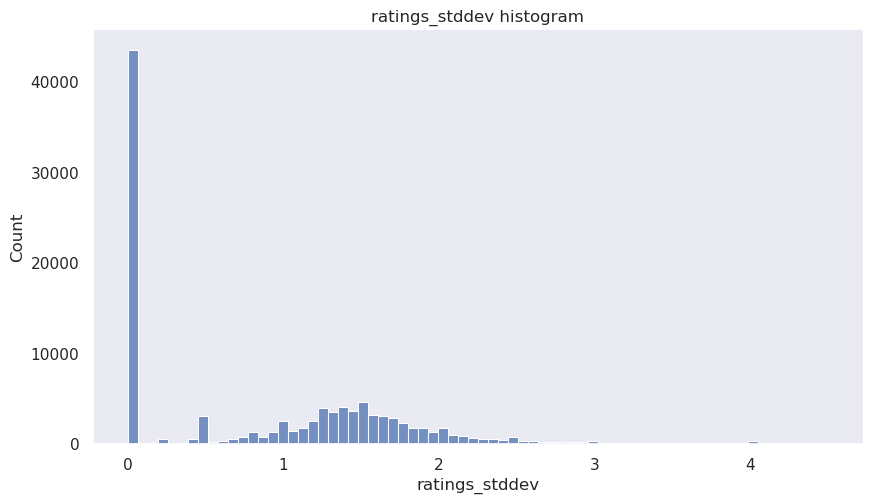

In [50]:
g = sns.displot(
        data=gen_df,
        x='ratings_stddev',
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE
);

g.set(title='ratings_stddev histogram')

#### `ratings_median`

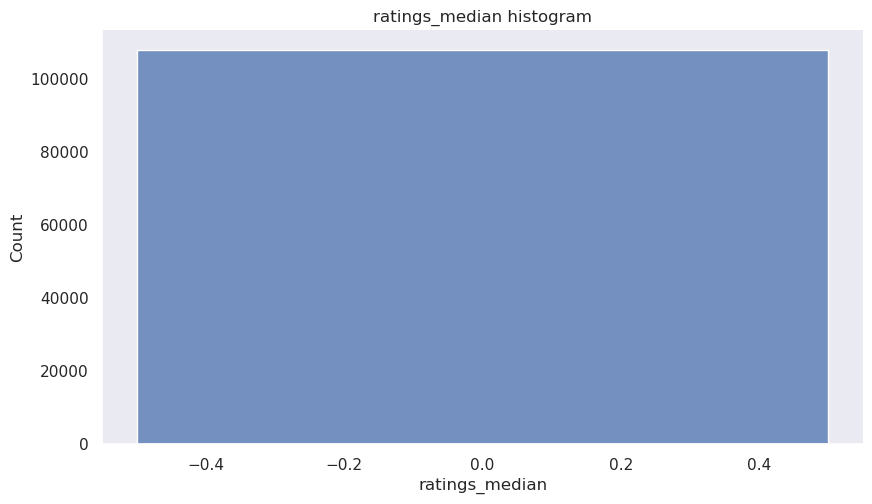

In [51]:
g = sns.displot(
        data=gen_df,
        x='ratings_median',
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE
);

g.set(title='ratings_median histogram')

#### `ratings_owned`

In [52]:
gen_df.sort_values('ratings_owned', ascending=False).head(10)

,id,type,name,description,year_published,players_min,players_max,playtime,playtime_min,playtime_max,...,ratings_bayes_average,ratings_stddev,ratings_median,ratings_owned,ratings_trading,ratings_wanting,ratings_wishing,ratings_comments_n,ratings_weights_n,ratings_weights_average
14712,30549,boardgame,Pandemic,"In Pandemic, several virulent diseases have br...",2008,2,4,45,45,45,...,7.468,1.3308,0.0,178195,2741,610,9545,17935,5746,2.406
74106,13,boardgame,CATAN,"In CATAN (formerly The Settlers of Catan), pla...",1995,3,4,120,60,120,...,6.952,1.4858,0.0,178072,2125,472,6127,20125,7691,2.307
59625,822,boardgame,Carcassonne,Carcassonne is a tile-placement game in which ...,2000,2,5,45,30,45,...,7.305,1.3060,0.0,169874,1808,651,7822,19870,7854,1.902
65015,178900,boardgame,Codenames,Codenames is an easy party game to solve puzzl...,2015,2,8,15,15,15,...,7.487,1.3010,0.0,128906,1220,339,6047,10424,2024,1.275
38682,68448,boardgame,7 Wonders,You are the leader of one of the 7 great citie...,2010,2,7,30,30,30,...,7.614,1.2747,0.0,126649,1725,983,12497,15050,4906,2.323
11633,173346,boardgame,7 Wonders Duel,In many ways 7 Wonders Duel resembles its pare...,2015,2,2,30,30,30,...,7.979,1.1850,0.0,123607,764,935,9465,10321,2402,2.221
88258,167791,boardgame,Terraforming Mars,"In the 2400s, mankind begins to terraform the ...",2016,1,5,120,120,120,...,8.254,1.3943,0.0,112420,638,1922,20194,11810,3357,3.250
14749,9209,boardgame,Ticket to Ride,"With elegantly simple gameplay, Ticket to Ride...",2004,2,5,60,30,60,...,7.297,1.2973,0.0,112399,990,685,6883,13501,4777,1.841
45116,36218,boardgame,Dominion,"""You are a monarch, like your parents before y...",2008,2,4,30,30,30,...,7.491,1.4222,0.0,110897,2069,651,8907,14068,5053,2.353
44526,230802,boardgame,Azul,"Introduced by the Moors, azulejos (originally ...",2017,2,4,45,30,45,...,7.667,1.1509,0.0,107908,579,1035,11766,8862,1840,1.761


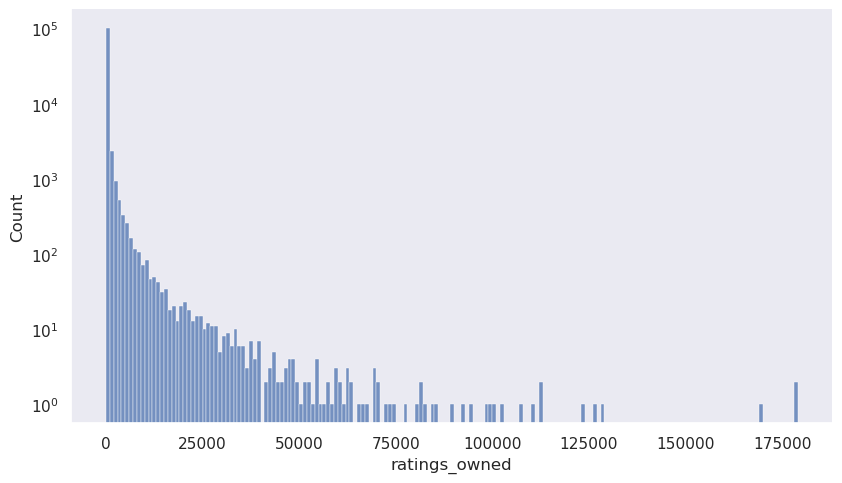

In [53]:
g = sns.displot(data=gen_df,
                x='ratings_owned',
                kind='hist',
                binwidth=1000,
                height=HEIGHT_STANDARD,
                aspect=ASPECT_WIDE);

g.set(yscale='log');

In [54]:
gen_df['ratings_owned'].describe()

count    108015.000000
mean        340.307948
std        2675.559029
min           0.000000
25%           2.000000
50%           8.000000
75%          57.000000
max      178195.000000
Name: ratings_owned, dtype: float64

In [55]:
au.print_titled_text("Proportion of games with no owners")
(gen_df['ratings_owned'] == 0).mean().round(3)

PROPORTION OF GAMES WITH NO OWNERS


0.112

#### `ratings_trading`

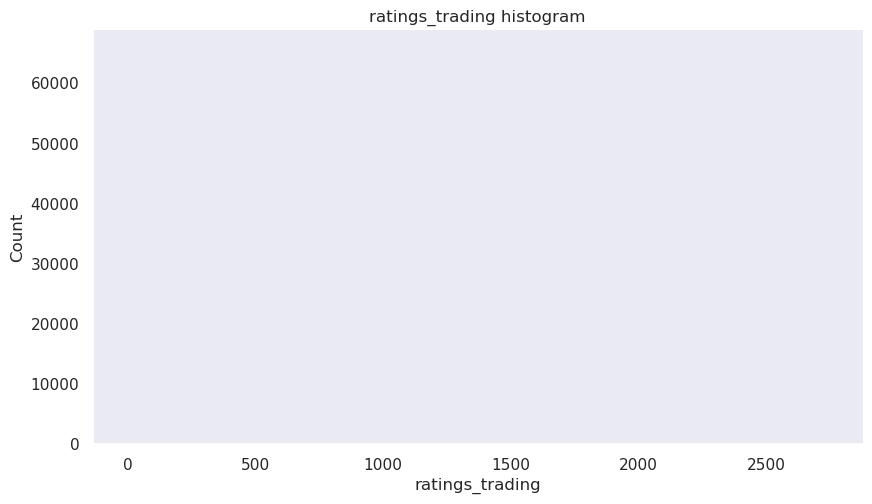

In [56]:
g = sns.displot(
        data=gen_df,
        x='ratings_trading',
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE
);

g.set(title='ratings_trading histogram')

#### `ratings_wanting`

In [ ]:
g = sns.displot(
        data=gen_df,
        x='ratings_wanting',
        binwidth=10,
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE
);

g.set(title='ratings_wanting histogram')

AttributeError: 'Rectangle' object has no property 'bin_width'

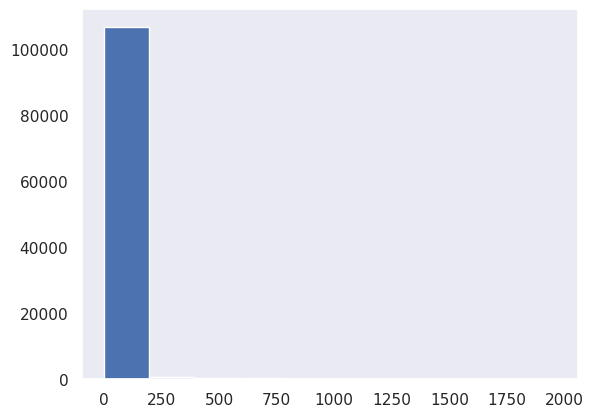

In [63]:
gen_df['ratings_wanting'].hist(bin_width=10)

#### `ratings_wishing`

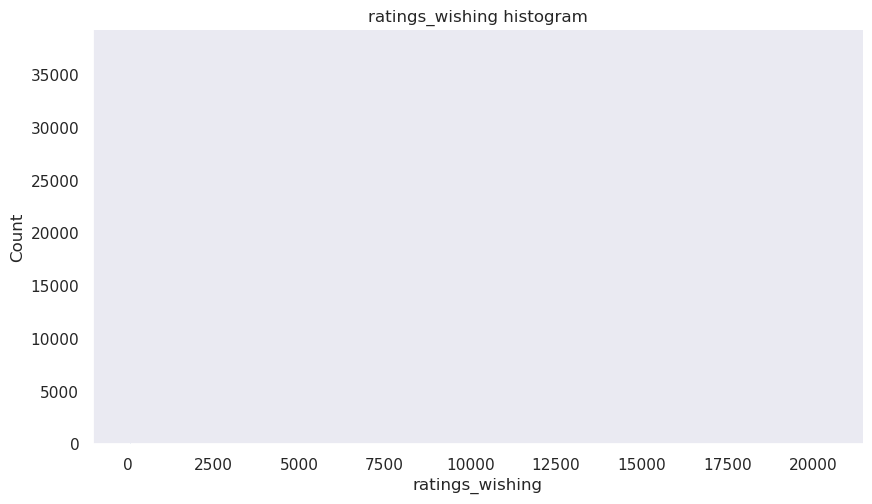

In [58]:
g = sns.displot(
        data=gen_df,
        x='ratings_wishing',
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE
);

g.set(title='ratings_wishing histogram')

#### `ratings_comments_n`

In [59]:
g = sns.displot(
        data=gen_df,
        x='ratings_comments_n',
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE
);

g.set(title='ratings_comments_n histogram')

Error in callback <function flush_figures at 0x7fa2349d40d0> (for post_execute):


KeyboardInterrupt: 

#### `ratings_weights_n`

KeyboardInterrupt: 

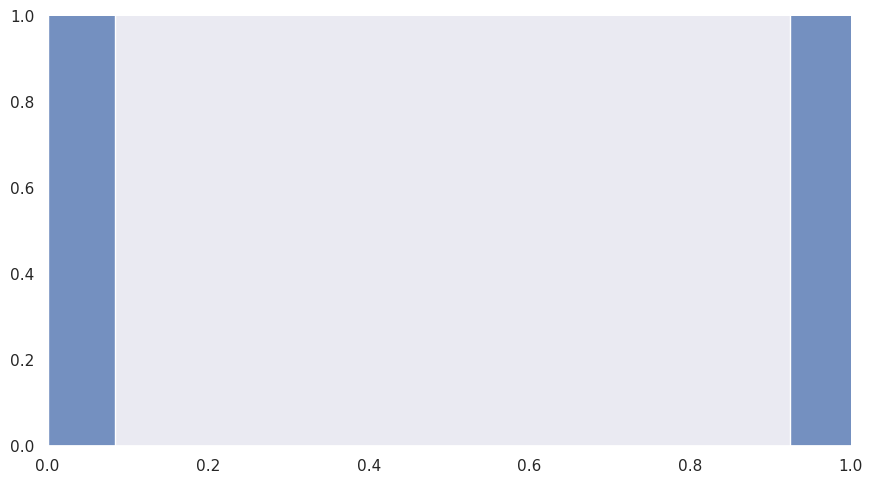

In [60]:
g = sns.displot(
        data=gen_df,
        x='ratings_weights_n',
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE
);

g.set(title='ratings_weights_n histogram')

#### `ratings_weights_average`

In [ ]:
g = sns.displot(
        data=gen_df,
        x='ratings_weights_average',
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE
);

g.set(title='ratings_weights_average histogram')

### Part 2

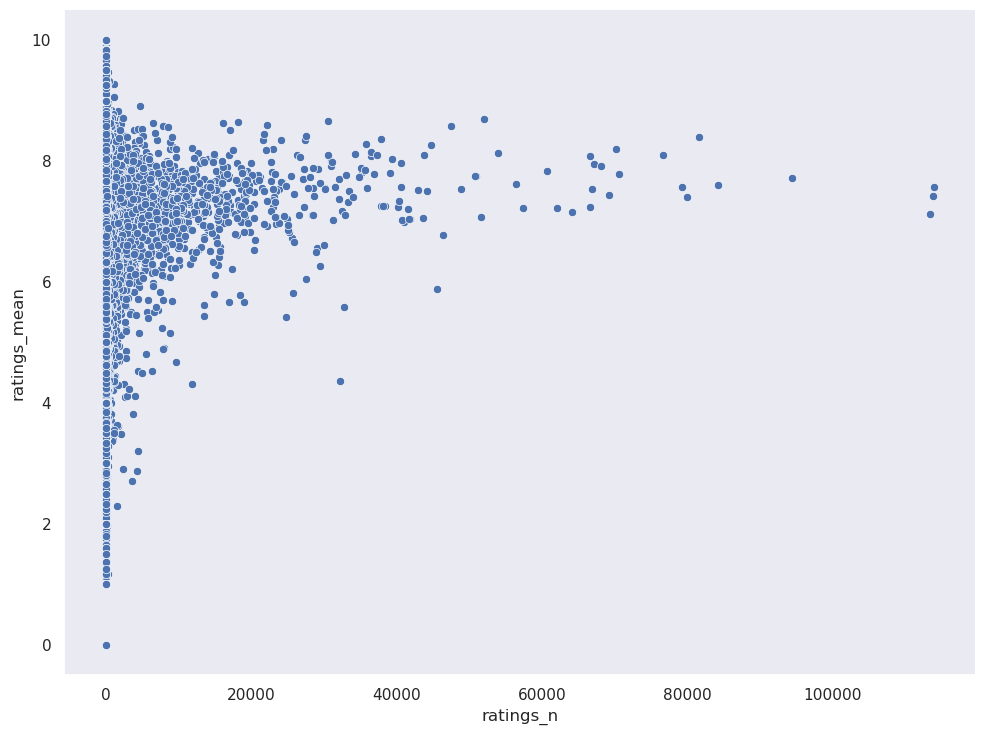

In [77]:
sns.relplot(data=gen_df,
            x='ratings_n',
            y='ratings_mean',
            height=HEIGHT_STANDARD*1.5,
            aspect=ASPECT_NARROW,
           );

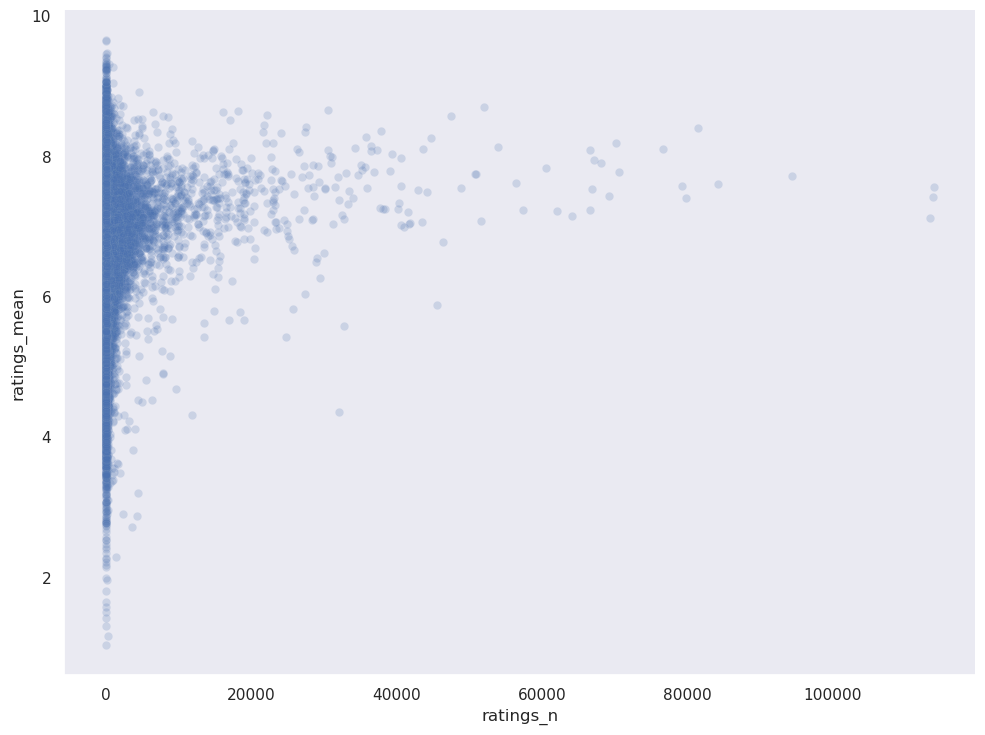

In [78]:
sns.relplot(data=gen_df.query("ratings_n > 21"),
            x='ratings_n',
            y='ratings_mean',
            height=HEIGHT_STANDARD*1.5,
            aspect=ASPECT_NARROW,
            linewidth=0.1,
            alpha=0.2
           );

In [79]:
gen_df.query("ratings_bayes_average == 0")['ratings_n'].describe()

count    84697.000000
mean         4.333034
std          6.334995
min          0.000000
25%          0.000000
50%          2.000000
75%          6.000000
max         29.000000
Name: ratings_n, dtype: float64

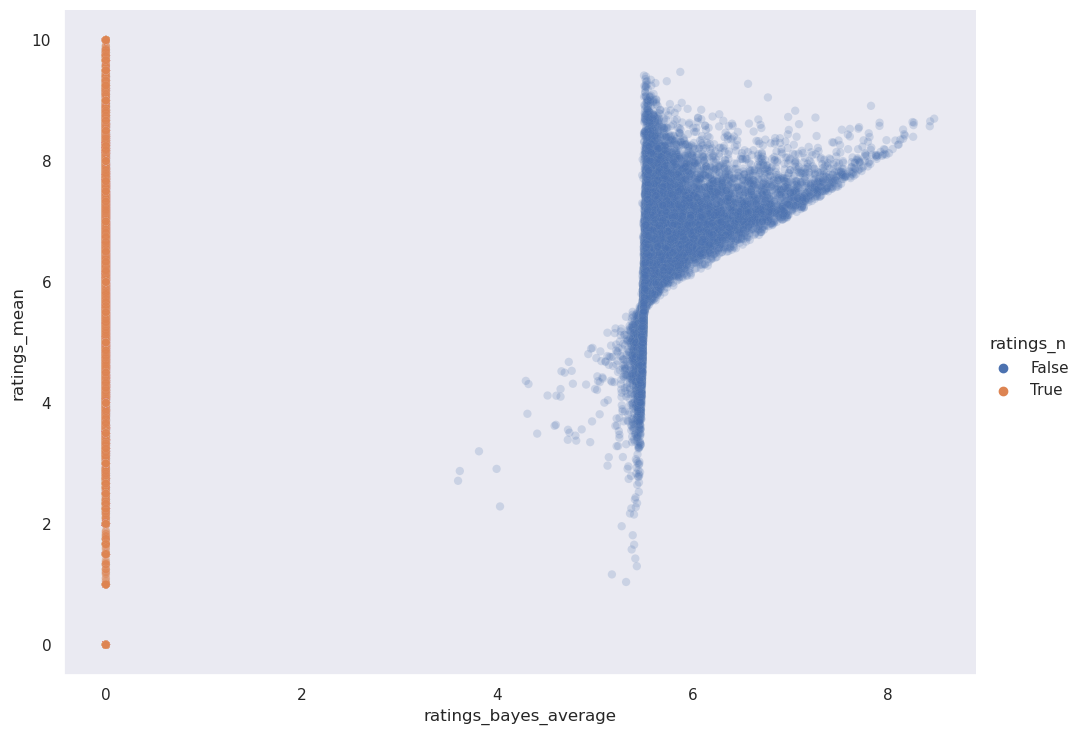

In [80]:
sns.relplot(data=gen_df,
            x='ratings_bayes_average',
            y='ratings_mean',
            hue=gen_df['ratings_n'] <= 29,
            height=HEIGHT_STANDARD*1.5,
            aspect=ASPECT_NARROW,
            linewidth=0.1,
            alpha=0.2
           );

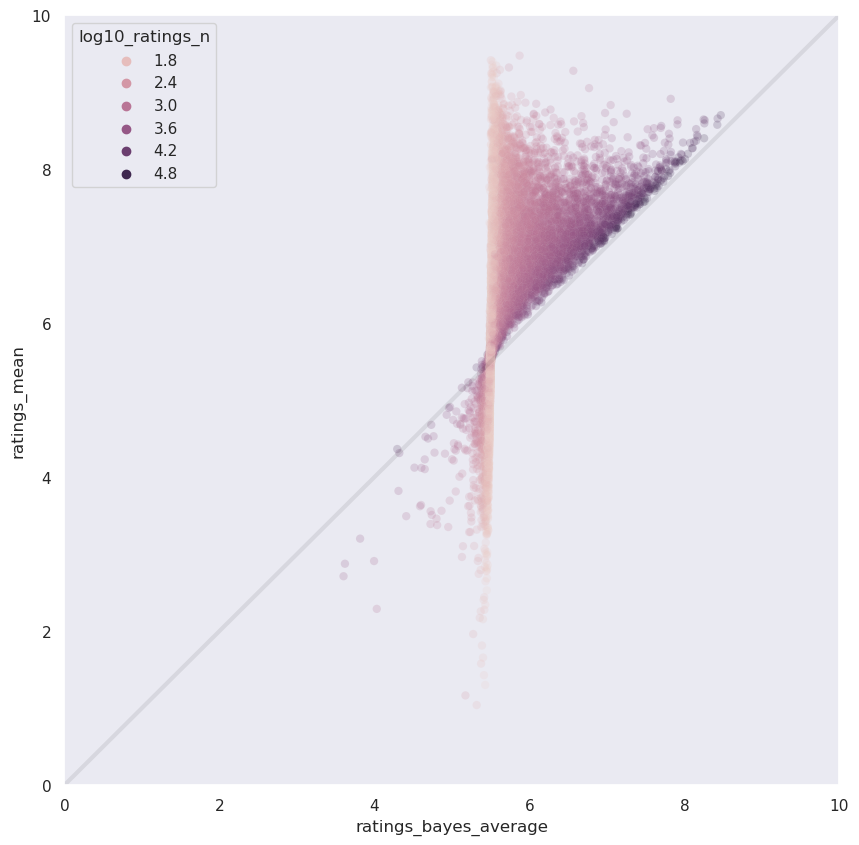

In [81]:
data = gen_df.query("ratings_bayes_average > 0")
log_ratings_n = np.log10(data['ratings_n'])
log_ratings_n.name = "log10_ratings_n"
f, ax = plt.subplots(
    1,
    1,
    figsize=(HEIGHT_STANDARD*2, HEIGHT_STANDARD*2))
sns.scatterplot(
        ax=ax,
        data=data,
        x='ratings_bayes_average',
        y='ratings_mean',
        hue=log_ratings_n,
        linewidth=0.1,
        alpha=0.2
        );

ax.set_xlim([0,10])
ax.set_ylim([0,10])
# x=y
ax.plot([0,10],[0,10],
        alpha=0.08,
        linewidth=3,
        color='black');


In [82]:
# TODO reverse engineer fuzzing algo

In [83]:
gen_df['ratings_n'].describe()

count    108015.000000
mean        194.979262
std        1802.471195
min           0.000000
25%           1.000000
50%           3.000000
75%          21.000000
max      113935.000000
Name: ratings_n, dtype: float64

### Link data

In [ ]:
link_df.head()

In [ ]:
link_df.shape

In [ ]:
link_df.info()

In [ ]:
link_df.describe()

In [ ]:
link_df.groupby('type').nunique()

In [ ]:
display(link_df[link_df['inbound'].notna()].shape)
link_df[link_df['inbound'].notna()].head()


## Part 3 When is the golden age of board games
- link data rise of certain types of games

In [ ]:
# Could trim off low ratings a la BGG

In [89]:
min_rating_n = (gen_df
                .query("ratings_bayes_average > 0")
                .ratings_n
                .min()
                )
min_rating_n

30

In [90]:
rated_df = gen_df.query("ratings_bayes_average > 0")

In [138]:
rated = gen_df.query("ratings_bayes_average > 0")

In [91]:
rated_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23318 entries, 3 to 108014
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       23318 non-null  int64  
 1   type                     23318 non-null  object 
 2   name                     23318 non-null  object 
 3   description              23317 non-null  object 
 4   year_published           23318 non-null  int64  
 5   players_min              23318 non-null  int64  
 6   players_max              23318 non-null  int64  
 7   playtime                 23318 non-null  int64  
 8   playtime_min             23318 non-null  int64  
 9   playtime_max             23318 non-null  int64  
 10  age_min                  23318 non-null  int64  
 11  ratings_n                23318 non-null  int64  
 12  ratings_mean             23318 non-null  float64
 13  ratings_bayes_average    23318 non-null  float64
 14  ratings_stddev       

In [92]:
rated_df.describe()

,id,year_published,players_min,players_max,playtime,playtime_min,playtime_max,age_min,ratings_n,ratings_mean,ratings_bayes_average,ratings_stddev,ratings_median,ratings_owned,ratings_trading,ratings_wanting,ratings_wishing,ratings_comments_n,ratings_weights_n,ratings_weights_average
count,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.0,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000
mean,126683.275066,1986.641779,1.995454,5.755168,90.825028,62.452397,90.825028,9.639892,887.455614,6.439447,5.682265,1.524332,0.0,1528.389527,43.067416,40.946779,237.395789,212.212068,48.754096,1.979245
std,110356.808154,209.545550,0.699209,14.898702,522.300785,431.042046,522.300785,3.649204,3799.808928,0.937372,0.362250,0.293628,0.0,5599.966889,103.150991,114.608912,820.796402,679.267515,205.750925,0.850962
min,1.000000,-3500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,1.039000,3.601000,0.191200,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,13884.250000,2002.000000,2.000000,4.000000,25.000000,20.000000,25.000000,8.000000,56.000000,5.850000,5.510000,1.324825,0.0,150.000000,5.000000,3.000000,14.000000,24.000000,4.000000,1.333000
50%,123595.500000,2012.000000,2.000000,4.000000,45.000000,30.000000,45.000000,10.000000,124.000000,6.468000,5.544000,1.483600,0.0,325.000000,13.000000,9.000000,40.000000,50.000000,9.000000,1.974500
75%,221289.250000,2017.000000,2.000000,6.000000,90.000000,60.000000,90.000000,12.000000,401.000000,7.070000,5.672000,1.672050,0.0,921.000000,37.000000,28.000000,133.000000,138.000000,25.000000,2.514000
max,362202.000000,2023.000000,10.000000,999.000000,60000.000000,60000.000000,60000.000000,21.000000,113935.000000,9.473000,8.469000,4.417600,0.0,178195.000000,2741.000000,1960.000000,20430.000000,20125.000000,7854.000000,5.000000


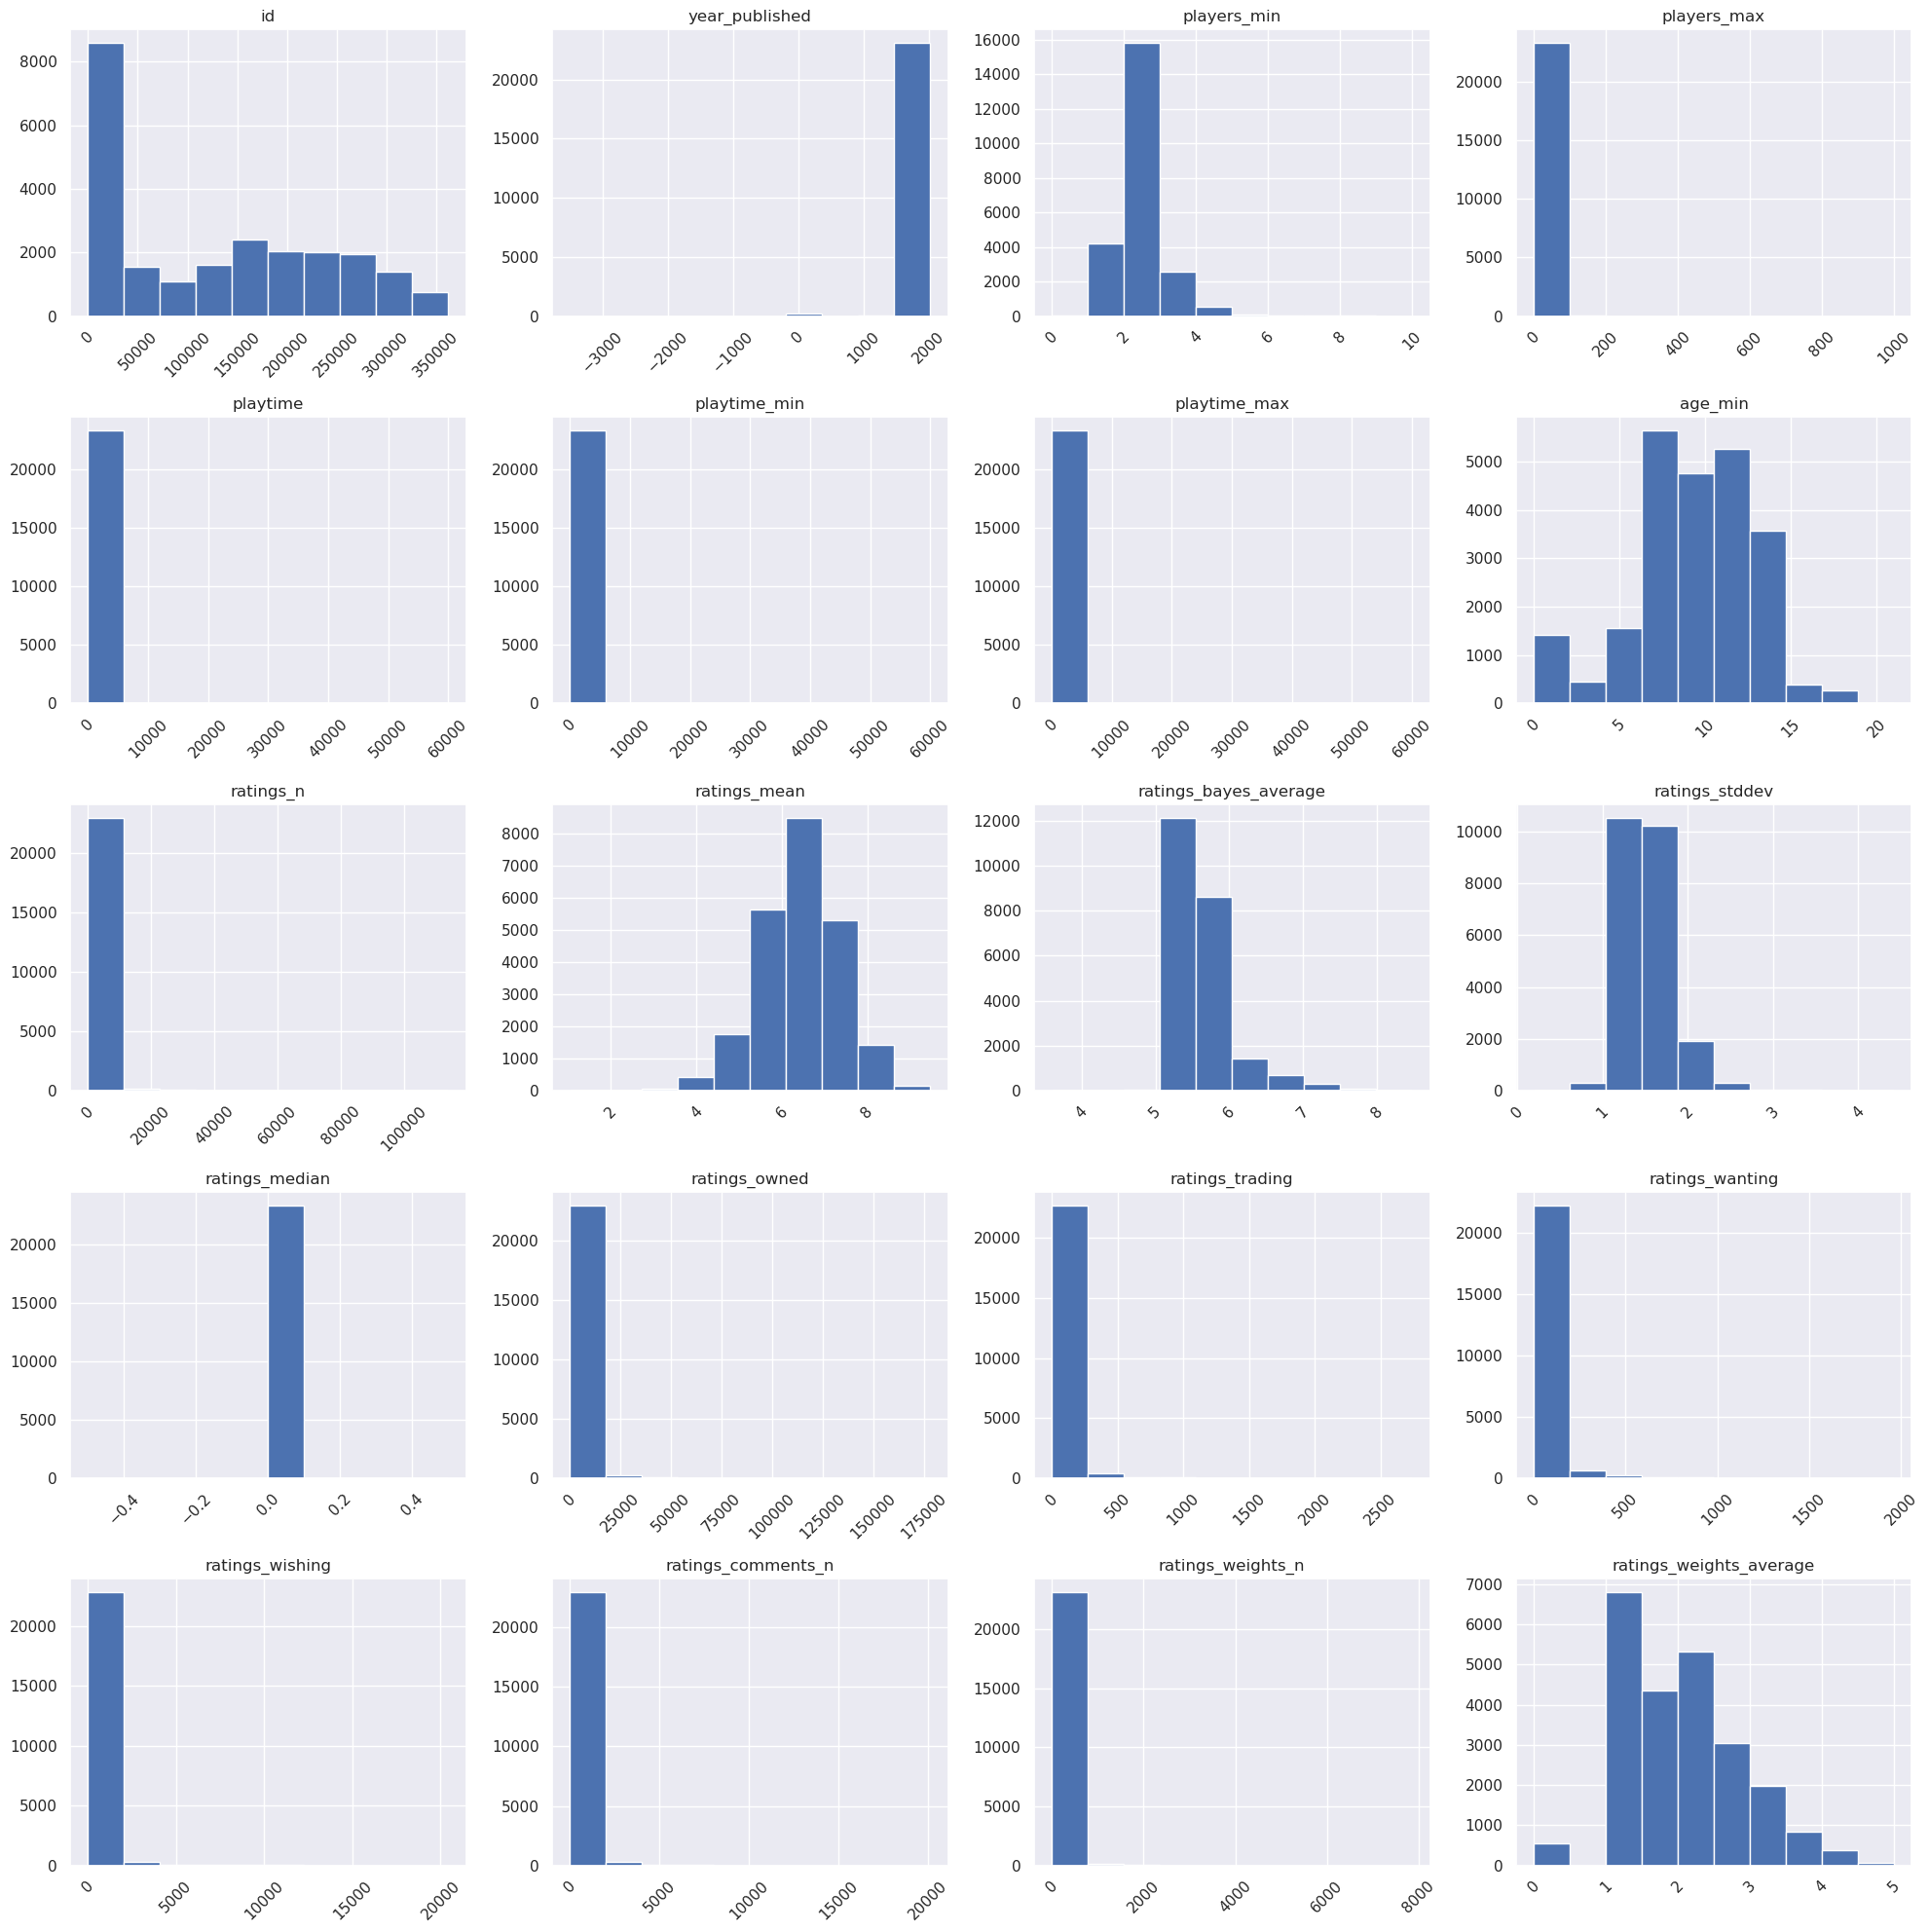

In [101]:
axes = rated_df.hist(figsize=(20,20), xrot=45)
axes[0,0].get_figure().tight_layout()

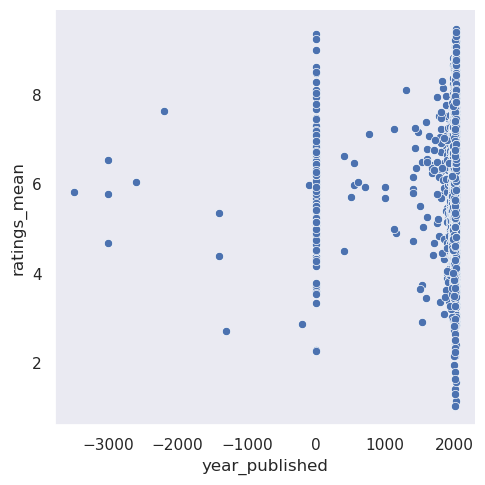

In [103]:
g = sns.relplot(
        kind='scatter',
        data=rated_df,
        x='year_published',
        y='ratings_mean'
)

In [104]:
nt1900_rated_df = rated_df.query("year_published > 1900")

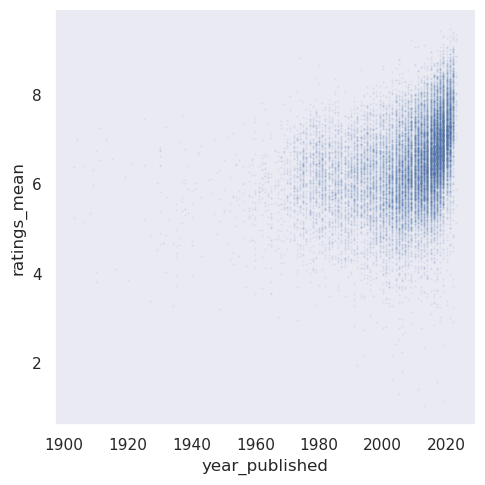

In [115]:
g = sns.relplot(
        kind='scatter',
        data=nt1900_rated_df,
        x='year_published',
        y='ratings_mean',
        alpha=0.1,
        s=2,
        linewidth=0
)

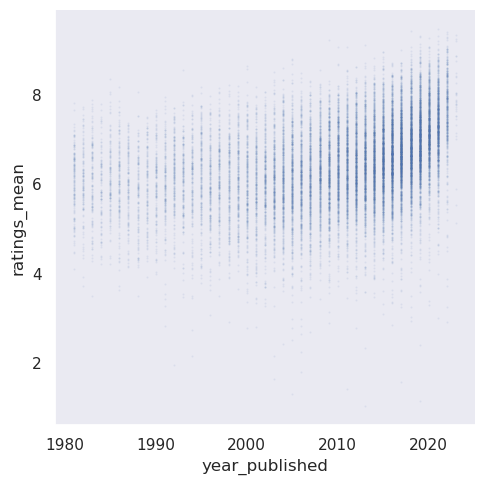

In [117]:
g = sns.relplot(
        kind='scatter',
        data=rated_df.query('year_published > 1980'),
        x='year_published',
        y='ratings_mean',
        alpha=0.1,
        s=2,
        linewidth=0
)

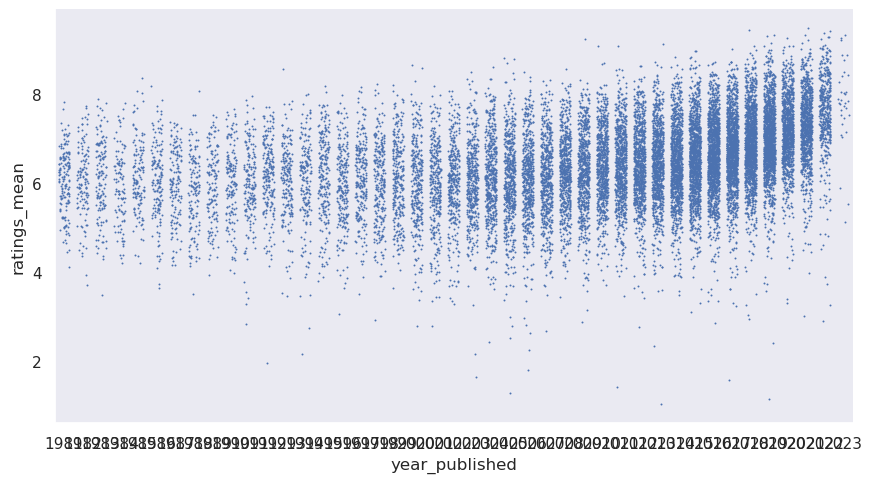

In [128]:
g = sns.catplot(
        kind='strip',
        data=rated_df.query('year_published > 1980'),
        x='year_published',
        y='ratings_mean',
        s=2,
        jitter=.3,
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE
)

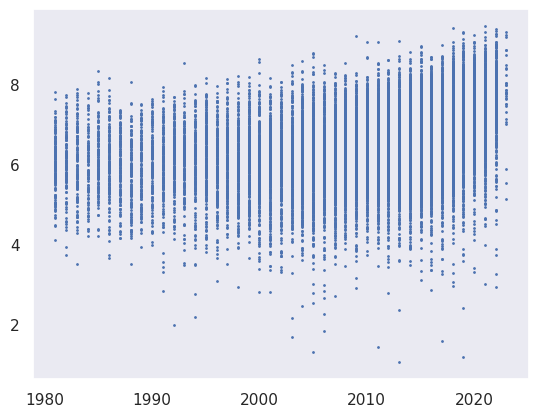

In [136]:
def plot_year_vs_rating_mean(df):
    fig, ax=plt.subplots(1,1)
    ax.scatter(df['year_published'], df['ratings_mean'], s=1)

plot_year_vs_rating_mean(rated_df.query('year_published > 1980'))



In [149]:
rated.year_published.quantile(np.linspace(0, 1, num=101))

0.00   -3500.00
0.01    1446.78
0.02    1958.00
0.03    1970.00
0.04    1974.00
         ...   
0.96    2021.00
0.97    2021.00
0.98    2022.00
0.99    2022.00
1.00    2023.00
Name: year_published, Length: 101, dtype: float64

In [148]:
(rated.year_published == 0).mean()

0.008619950253023416

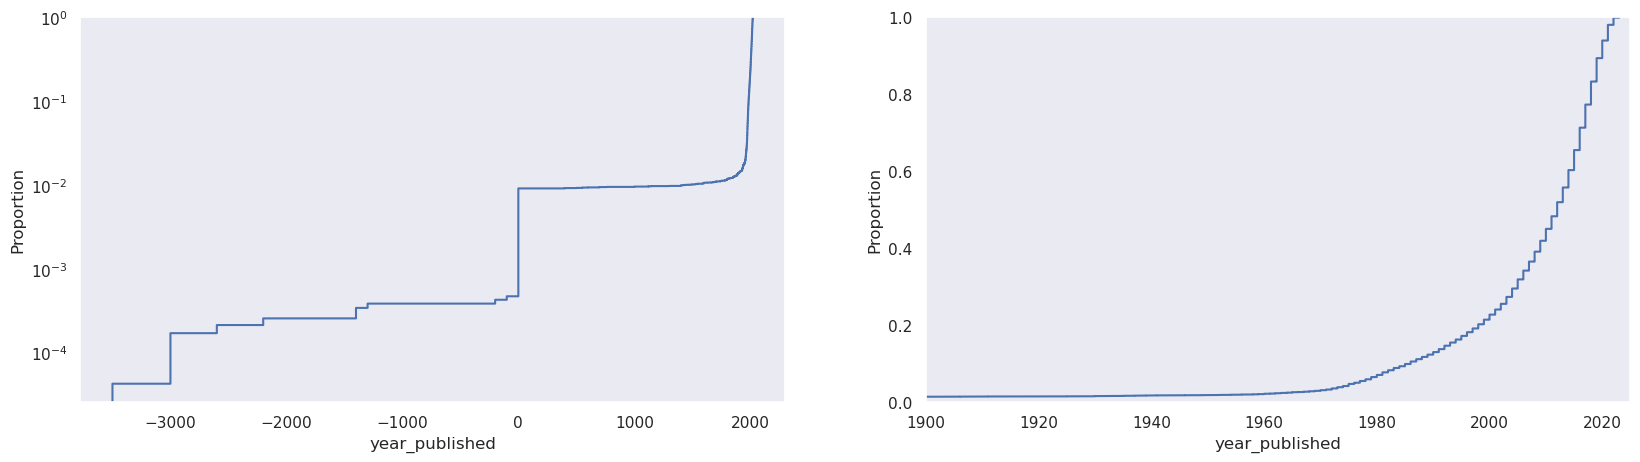

In [185]:
f, ax = plt.subplots(1, 2, figsize=(20,5))
sns.ecdfplot(ax=ax[0], data=rated, x='year_published', log_scale=(False,True))
sns.ecdfplot(ax=ax[1], data=rated, x='year_published')
ax[1].set_xlim(1900, 2025);

In [188]:
rated.query('year_published != 0')['year_published'].quantile(0.01)

1953.0

In [189]:
modern = rated.query('year_published > 1945')

In [191]:
# mean modern rating over time per year
# Note: all games are weighted equally.
modern_r_mean_vs_year = modern.groupby('year_published').ratings_mean.mean()

<AxesSubplot:xlabel='year_published', ylabel='ratings_mean'>

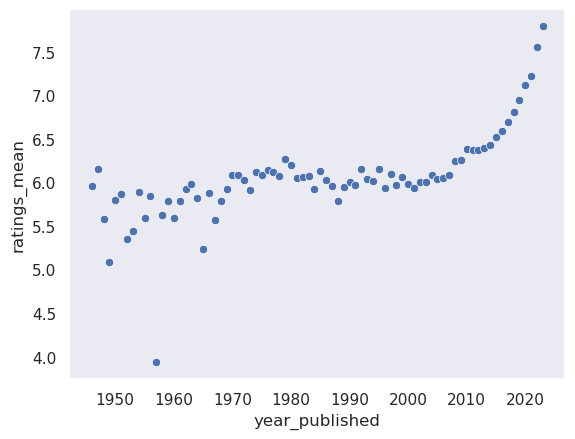

In [195]:
sns.scatterplot(data = modern_r_mean_vs_year)

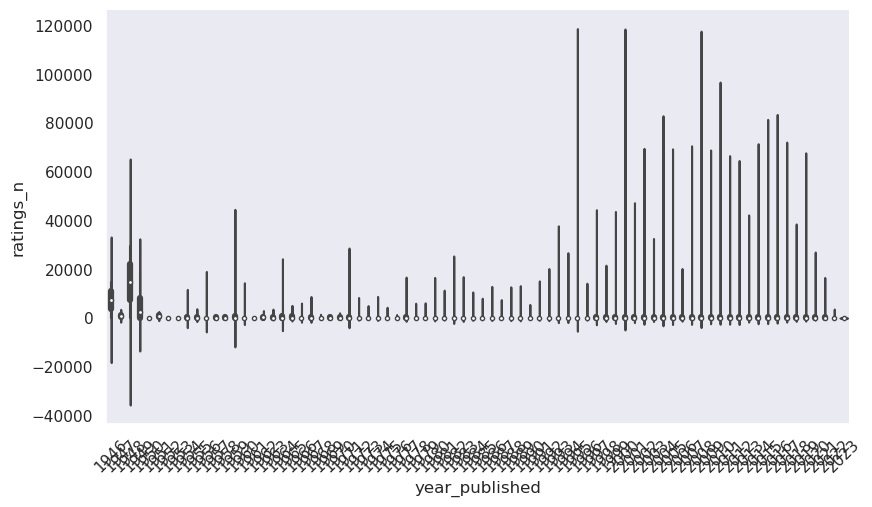

In [205]:
g = sns.catplot(kind='violin', data=modern, x='year_published', y='ratings_n', height=HEIGHT_STANDARD, aspect=ASPECT_WIDE, log_scale=(False, True))
g.set_xticklabels(rotation=45);

In [203]:
modern.shape[0]/70

327.25714285714287

In [ ]:
f, ax = plt.subplots(figsize=(20,5))


In [217]:
modern_by_year = modern.groupby('year_published')
cnt = modern_by_year.count()['id'].rename('count')
r_mean = modern_by_year['ratings_mean'].mean()

In [218]:
cnt.head()

year_published
1946    2
1947    2
1948    2
1949    4
1950    4
Name: count, dtype: int64

In [219]:
r_mean.head()

year_published
1946    5.95900
1947    6.16100
1948    5.57950
1949    5.08825
1950    5.80300
Name: ratings_mean, dtype: float64

In [221]:
modern_by_year['ratings_n'].sum()

year_published
1946      15056
1947       1941
1948      29657
1949      23774
1950        591
         ...   
2019    1061127
2020     606937
2021     397030
2022      97070
2023       2129
Name: ratings_n, Length: 78, dtype: int64

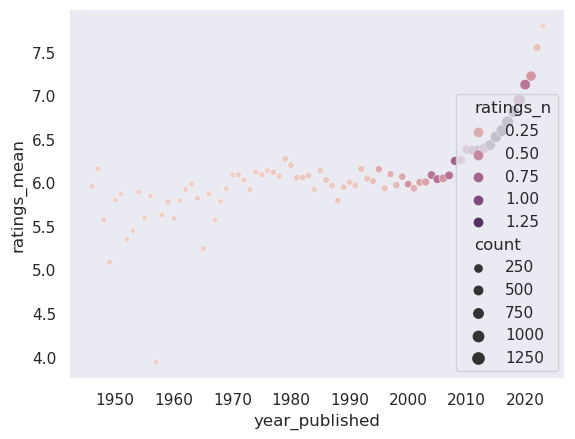

In [251]:
g = sns.scatterplot(x=cnt.index, y=r_mean, size=cnt, hue=modern_by_year['ratings_n'].sum())

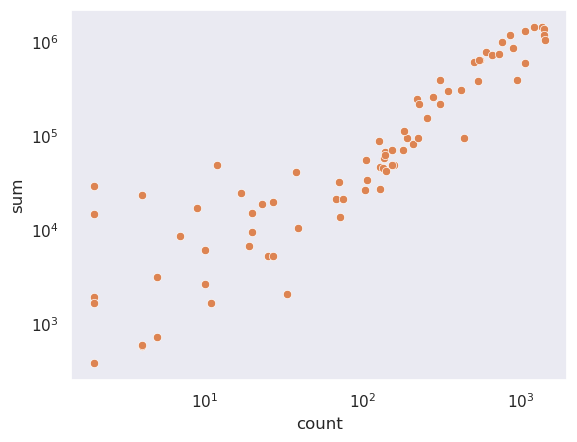

In [234]:
agg = modern_by_year.agg({'ratings_n': ['sum', 'count', 'mean']})
g = sns.scatterplot(x=agg['ratings_n']['count'], y=agg['ratings_n']['sum'])
g2 = sns.scatterplot(x=agg['ratings_n']['count'], y=agg['ratings_n']['sum'])
g2.set_yscale('log')
g2.set_xscale('log')

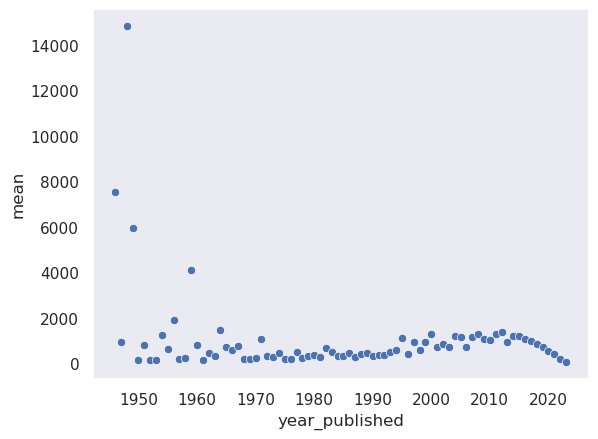

In [237]:
g = sns.scatterplot(x=agg.index, y=agg['ratings_n']['mean'])

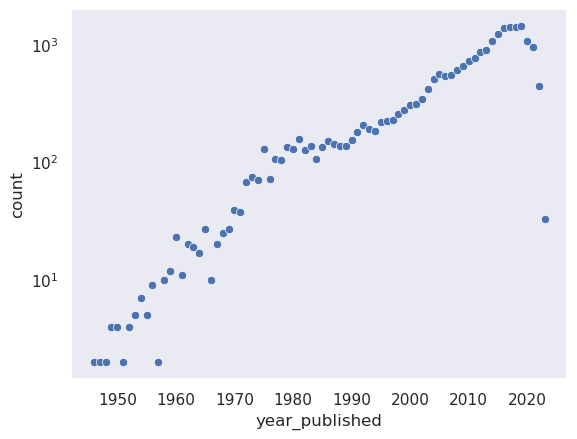

In [240]:
g = sns.scatterplot(x=agg.index, y=agg['ratings_n']['count'])
g.set_yscale('log')

In [243]:
modern.query('year_published < 1950')[['name','ratings_n', 'year_published']].sort_values('ratings_n', ascending=False)

,name,ratings_n,year_published
58285,Scrabble,29418,1948
85015,Clue,19010,1949
101522,Stratego,14976,1946
80940,Candy Land,4445,1949
4208,Subbuteo,1731,1947
102289,Finans,270,1949
40313,Electric Football,239,1948
98783,Qubic,210,1947
52751,Rich Uncle,80,1946
89266,Subbuteo Cricket,49,1949


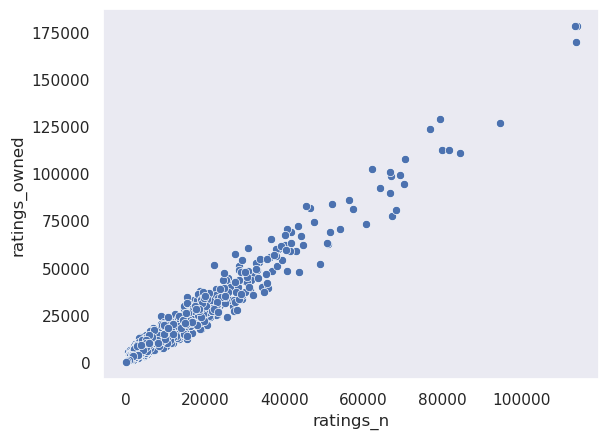

In [244]:
g = sns.scatterplot(data=modern, x='ratings_n', y='ratings_owned')

In [249]:
modern.loc[:,'ratings_n':].corr()

,ratings_n,ratings_mean,ratings_bayes_average,ratings_stddev,ratings_median,ratings_owned,ratings_trading,ratings_wanting,ratings_wishing,ratings_comments_n,ratings_weights_n,ratings_weights_average
ratings_n,1.000000,0.167634,0.638283,-0.109784,NaN,0.985033,0.816247,0.717847,0.821953,0.973900,0.914990,0.086530
ratings_mean,0.167634,1.000000,0.465438,-0.314548,NaN,0.177000,0.122570,0.324285,0.278994,0.176678,0.145273,0.480520
ratings_bayes_average,0.638283,0.465438,1.000000,-0.275372,NaN,0.646094,0.619211,0.837336,0.777425,0.673748,0.566763,0.283778
ratings_stddev,-0.109784,-0.314548,-0.275372,1.000000,NaN,-0.114616,-0.116962,-0.163220,-0.123394,-0.117939,-0.089407,-0.000480
ratings_median,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ratings_owned,0.985033,0.177000,0.646094,-0.114616,NaN,1.000000,0.829925,0.683744,0.804177,0.954475,0.871293,0.087617
ratings_trading,0.816247,0.122570,0.619211,-0.116962,NaN,0.829925,1.000000,0.556447,0.621570,0.869463,0.793811,0.124965
ratings_wanting,0.717847,0.324285,0.837336,-0.163220,NaN,0.683744,0.556447,1.000000,0.935919,0.727812,0.649531,0.245773
ratings_wishing,0.821953,0.278994,0.777425,-0.123394,NaN,0.804177,0.621570,0.935919,1.000000,0.794296,0.704402,0.191961
ratings_comments_n,0.973900,0.176678,0.673748,-0.117939,NaN,0.954475,0.869463,0.727812,0.794296,1.000000,0.951854,0.114311


<AxesSubplot:>

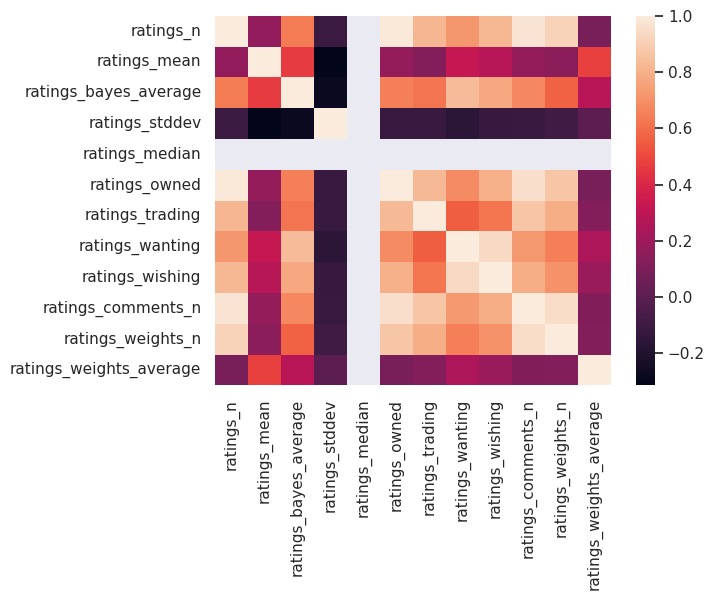

In [248]:
sns.heatmap(data=modern.loc[:,'ratings_n':].corr())

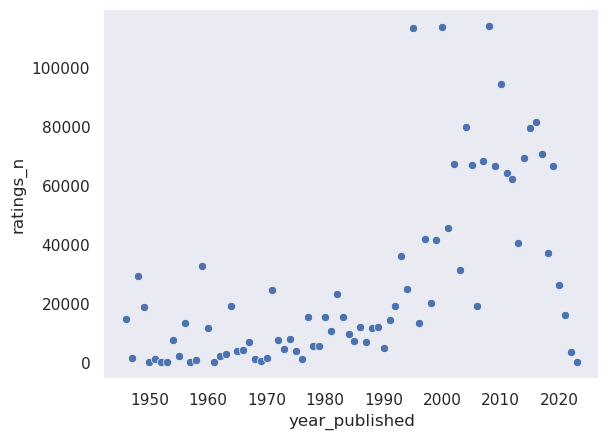

In [253]:
# Per year max ratings_n game?
g = sns.scatterplot(x=modern_by_year['ratings_n'].max().index, y=modern_by_year['ratings_n'].max())

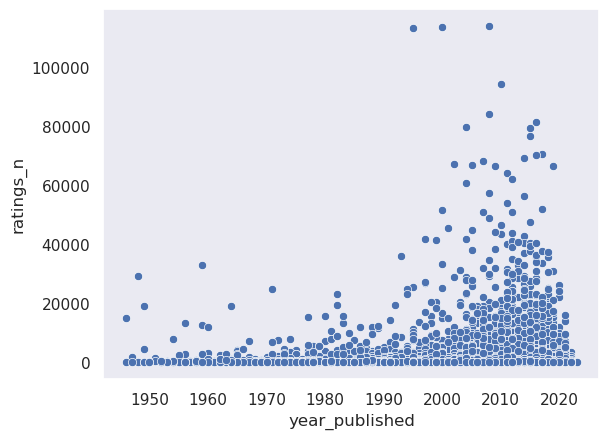

In [255]:
g = sns.scatterplot(data=modern, x='year_published', y='ratings_n')

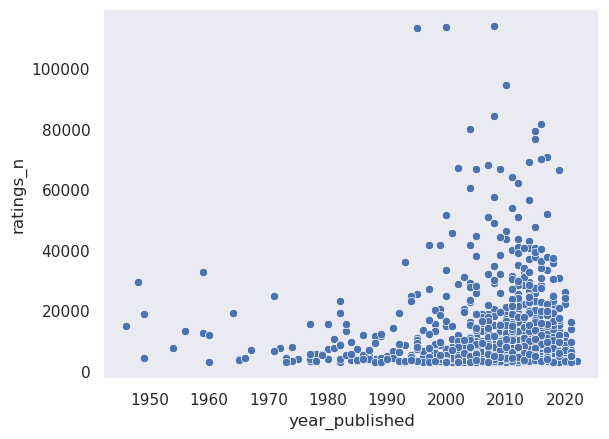

In [272]:
g = sns.scatterplot(data=modern.query('ratings_n > 3000'), x='year_published', y='ratings_n')

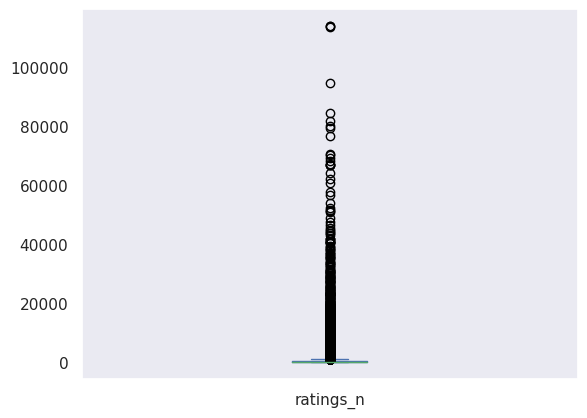

In [265]:
modern.ratings_n.plot.box();

In [268]:
q1 = modern.ratings_n.quantile(0.25)
q3 = modern.ratings_n.quantile(0.75)
iqr = q3-q1

In [270]:
modern.ratings_n.quantile(np.arange(0,1,0.05))

0.00      30.0
0.05      33.0
0.10      38.0
0.15      43.0
0.20      49.0
0.25      56.0
0.30      65.0
0.35      76.0
0.40      88.0
0.45     104.0
0.50     124.0
0.55     150.0
0.60     184.0
0.65     231.0
0.70     298.0
0.75     404.0
0.80     565.6
0.85     862.0
0.90    1493.0
0.95    3288.6
Name: ratings_n, dtype: float64

In [271]:
modern.shape[0]*0.05

1145.4

In [269]:
modern.ratings_n.quantile(0.75)

404.0

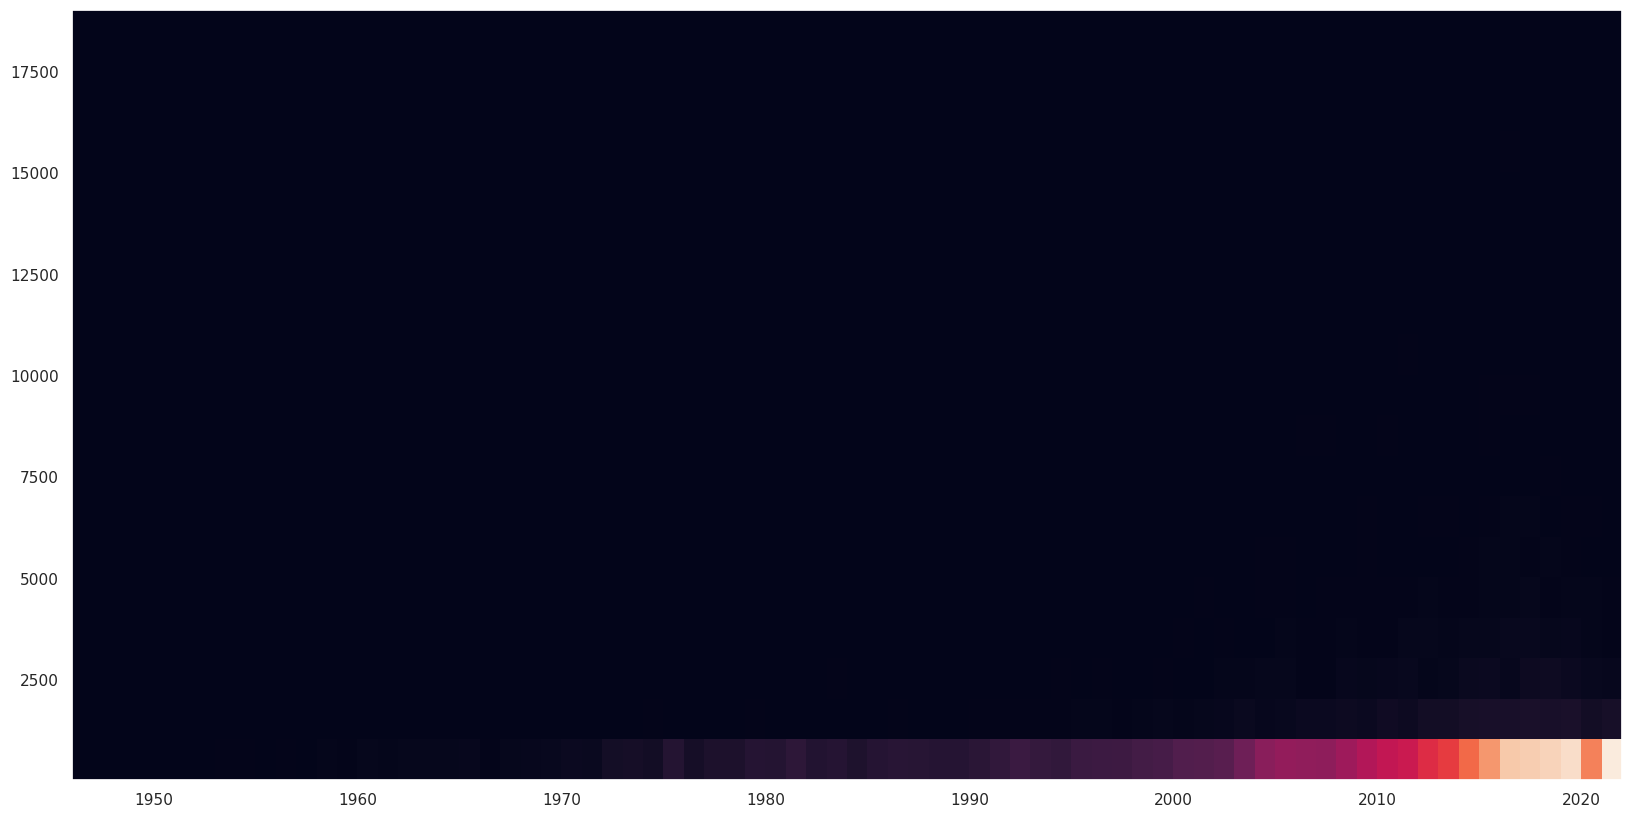

In [262]:
f, ax = plt.subplots(figsize=(20,10))
xmin = modern['year_published'].min()
xmax = modern['year_published'].max()
ymin = modern['ratings_n'].min()
ymax= modern['ratings_n'].max()
ax.hist2d(modern['year_published'], modern['ratings_n'], bins=(np.arange(xmin, xmax, 1), np.arange(ymin, 20000, 1000)));

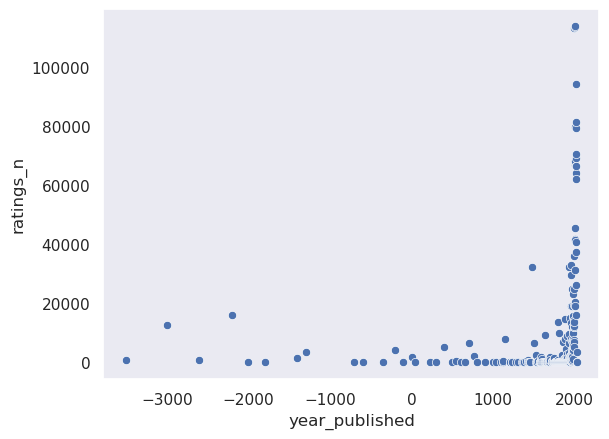

In [254]:
g=sns.scatterplot(x=gen_df.groupby('year_published')['ratings_n'].max().index, y=gen_df.groupby('year_published')['ratings_n'].max())

In [ ]:
modern